# Benchmark & Model Clustering Analysis

This notebook examines:
1. **Benchmark redundancy** — which benchmarks measure the same thing?
2. **Model similarity** — which models have similar capability profiles?
3. **Residual profiles** — after removing the "general ability" factor (PC1), what makes each model special?

## Data Pipeline

### 1. Data Source
Benchmark scores are loaded from a Google Sheet in **long format** with columns:
- `model_id` — unique model identifier
- `model` — human-readable model name
- `benchmark_id` — unique benchmark identifier
- `benchmark` — human-readable benchmark name
- `performance` — score in [0, 1]
- `benchmark_release_date` — when the benchmark was released

### 2. Filtering
- **Benchmark release year ≥ 2023** — only recent benchmarks are kept.
- **Models with ≥ `min_scores_per_model` scores** — models with too few benchmark results are dropped.
- Optional benchmark whitelist (disabled by default).

### 3. Pivot to Wide Matrix
`M = df_data.pivot_table(index='model_id', columns='benchmark_id', values='performance')`

This creates a **(models × benchmarks)** matrix with NaN where a model wasn't tested on a benchmark.

### 4. Imputation Pipeline: logit → KNN → expit
1. **Logit transform:** `logit(p) = log(p / (1-p))` — stretches scores near 0 and 1 onto (-∞, +∞), avoiding ceiling/floor effects. Scores are clipped to [ε, 1-ε] first. NaNs pass through unchanged.
2. **KNN imputation** (k=5, distance-weighted) in logit space — for each NaN, finds the 5 nearest models by Euclidean distance across shared observed benchmarks, fills the missing value as a distance-weighted average.
3. **Expit (sigmoid)** back to [0, 1]: `expit(z) = 1 / (1 + exp(-z))`.

Result: a **fully dense (models × benchmarks)** matrix in [0, 1].

### 5. For PCA-based analyses (residual profiles)
- **Column-wise z-score standardisation** (mean=0, std=1 per benchmark) so PCA operates on the correlation matrix.
- **PCA** extracts principal components; PC1 = the "g-factor" (general ability).

In [98]:
import pandas as pd

# --- knobs you can tweak ---
release_year_min = 2023       # keep benchmarks released in this year or later
min_scores_per_model =   8   # after filtering, each model must have >= this many scores

# Filter to a particular list of benchmarks (leave lists empty to skip)
allow_benchmarks_by_name = []
#    "GPQA diamond", "Aider polyglot", "OTIS Mock AIME 2024-2025", "LiveBench", "SimpleBench",
#                         "Balrog", "WeirdML", "FrontierMath-2025-02-28-Private", "SWE-Bench verified", "Cybench",
#                         "OSWorld", "VPCT", "Terminal Bench", "GeoBench", "Lech Mazur Writing", "DeepResearch Bench"

allow_benchmarks_by_id = [
    # e.g., "mmlu_v1", "gsm8k_2023"
]

# Replace with your actual Sheet ID and Tab GID
sheet_id = '1v3Uvw6pAdj5jKNnLhhBfaGHzeBgZIRor6qF8SuUR7AM'
tab_gid = '1152942641' #main: 282408316

# Construct the CSV export URL
google_sheet_url = f'https://docs.google.com/spreadsheets/d/{sheet_id}/export?format=csv&gid={tab_gid}'

try:
    df_data = pd.read_csv(google_sheet_url)

    # --- summary before filtering ---
    rows_before = len(df_data)
    models_before = df_data["model_id"].nunique() if "model_id" in df_data else None
    benches_before = df_data["benchmark_id"].nunique() if "benchmark_id" in df_data else None

    # --- required columns sanity check ---
    required_cols = ["model_id", "benchmark_id", "performance", "benchmark_release_date", "benchmark"]
    missing = [c for c in required_cols if c not in df_data.columns]
    if missing:
        raise KeyError(f"Missing required column(s): {missing}")

    # --- coerce types & parse dates ---
    df_data["performance"] = pd.to_numeric(df_data["performance"], errors="coerce")
    df_data["benchmark_release_date"] = pd.to_datetime(df_data["benchmark_release_date"], errors="coerce")

    # --- initial cleaning ---
    df_data = df_data.dropna(subset=["model_id", "benchmark_id", "performance", "benchmark_release_date"])

    # --- filter by release year ---
    df_data = df_data[df_data["benchmark_release_date"].dt.year >= release_year_min]

    # --- optional: filter to whitelist of benchmarks (by name and/or id) ---
    allowed_ids = set(str(x) for x in allow_benchmarks_by_id if str(x).strip())
    names_not_found = []

    if allow_benchmarks_by_name:
        tmp = (
            df_data[["benchmark_id", "benchmark"]]
            .dropna()
            .drop_duplicates()
        )
        name_to_ids = (
            tmp.assign(_name_norm=tmp["benchmark"].astype(str).str.strip().str.lower())
               .groupby("_name_norm")["benchmark_id"]
               .apply(lambda s: set(s.astype(str)))
               .to_dict()
        )
        for raw_name in allow_benchmarks_by_name:
            key = str(raw_name).strip().lower()
            if key in name_to_ids:
                allowed_ids |= name_to_ids[key]
            else:
                names_not_found.append(raw_name)

    if allowed_ids:
        df_data = df_data[df_data["benchmark_id"].astype(str).isin(allowed_ids)]

    # --- keep only models with at least min_scores_per_model scores after the above filters ---
    counts = df_data.groupby("model_id")["performance"].count()
    keep_models = counts[counts >= min_scores_per_model].index
    df_data = df_data[df_data["model_id"].isin(keep_models)]

    # --- summaries ---
    rows_after = len(df_data)
    models_after = df_data["model_id"].nunique()
    benches_after = df_data["benchmark_id"].nunique()

    print("Successfully loaded and filtered Google Sheet tab as CSV.")
    print(f"Rows: {rows_before} → {rows_after}")
    print(f"Models (unique): {models_before} → {models_after}")
    print(f"Benchmarks (unique): {benches_before} → {benches_after}")
    print(f"Kept benchmarks with release year ≥ {release_year_min} and models with ≥ {min_scores_per_model} scores.")
    if allow_benchmarks_by_name or allow_benchmarks_by_id:
        print(f"Whitelist active. Allowed IDs matched: {len(allowed_ids)}")
        if names_not_found:
            print("Names not found (after date filter):", ", ".join(map(str, names_not_found)))

        kept = (df_data[["benchmark_id", "benchmark"]]
                .drop_duplicates()
                .sort_values(["benchmark"]))
        print("Benchmarks kept:")
        display(kept)

    display(df_data.head())

except Exception as e:
    print(f'An error occurred while reading or filtering the Google Sheet: {e}')
    print("Please ensure the sheet is shared as 'Anyone with the link can view' and that required columns exist:")
    print("Required: model_id, benchmark_id, performance, benchmark_release_date, benchmark")

Successfully loaded and filtered Google Sheet tab as CSV.
Rows: 1097 → 331
Models (unique): 139 → 29
Benchmarks (unique): 39 → 24
Kept benchmarks with release year ≥ 2023 and models with ≥ 8 scores.


,benchmark_id,model_id,benchmark_release_date,benchmark,model,performance
82,b1,m62,2023-11-20,GPQA diamond,gpt-5-2025-08-07,0.816
83,b17,m62,2025-06-13,DeepResearch Bench,gpt-5-2025-08-07,0.560
84,b19,m62,2025-02-21,Fiction.LiveBench,gpt-5-2025-08-07,0.972
85,b2,m62,2025-02-28,FrontierMath-2025-02-28-Private,gpt-5-2025-08-07,0.266
86,b20,m62,2025-03-01,GeoBench,gpt-5-2025-08-07,0.810


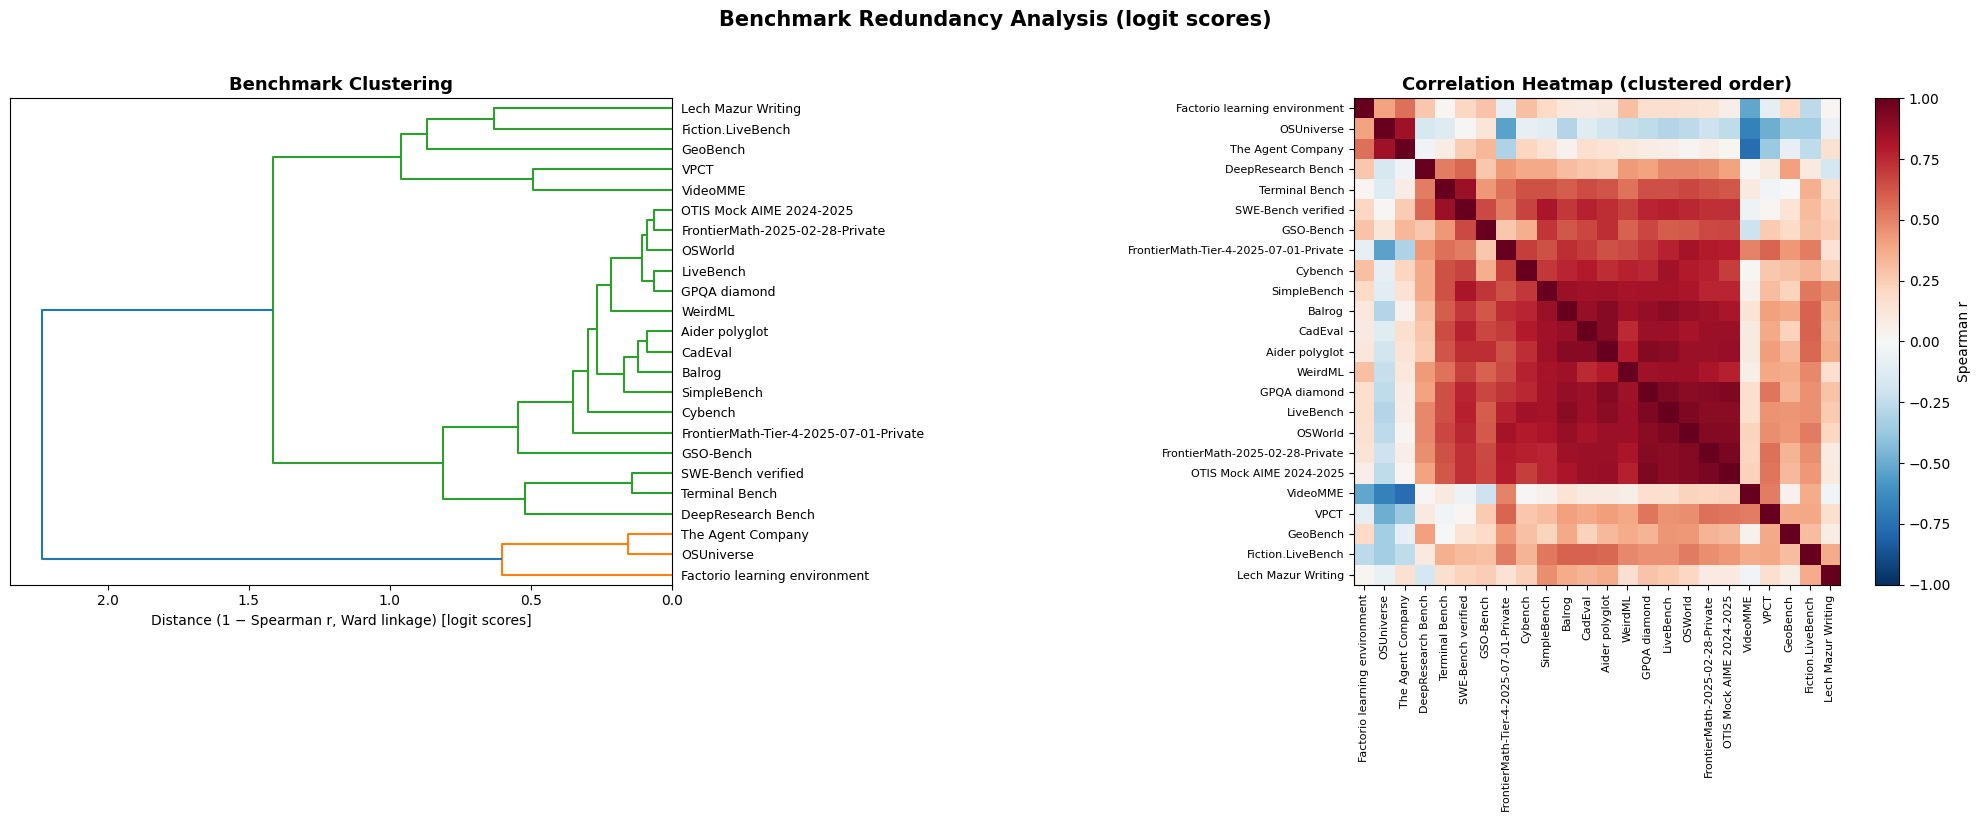


  3 clusters (Ward linkage)
  Cluster 1: Factorio learning environment, OSUniverse, The Agent Company
  Cluster 2: GPQA diamond, Balrog, CadEval, Cybench, DeepResearch Bench, FrontierMath-2025-02-28-Private, GSO-Bench, LiveBench, OSWorld, FrontierMath-Tier-4-2025-07-01-Private, SimpleBench, Terminal Bench, WeirdML, OTIS Mock AIME 2024-2025, SWE-Bench verified, Aider polyglot
  Cluster 3: Fiction.LiveBench, GeoBench, Lech Mazur Writing, VideoMME, VPCT

  5 clusters (Ward linkage)
  Cluster 1: Factorio learning environment, OSUniverse, The Agent Company
  Cluster 2: GPQA diamond, Balrog, CadEval, Cybench, DeepResearch Bench, FrontierMath-2025-02-28-Private, GSO-Bench, LiveBench, OSWorld, FrontierMath-Tier-4-2025-07-01-Private, SimpleBench, Terminal Bench, WeirdML, OTIS Mock AIME 2024-2025, SWE-Bench verified, Aider polyglot
  Cluster 3: VideoMME, VPCT
  Cluster 4: Fiction.LiveBench, Lech Mazur Writing
  Cluster 5: GeoBench

Within-cluster mean |r| (5 clusters):
  Cluster 1 (mean |r| = 0

In [99]:
# === Benchmark Redundancy: Hierarchical Clustering ===
# Which benchmarks are measuring the same thing?
# Cluster benchmarks by their pairwise Spearman correlations across models.

import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform

KNN_K = 5
EPS   = 1e-6
USE_LOGIT_FOR_CORRELATION = True   # True = correlate on logit(score); False = correlate on [0,1] scores
USE_IMPUTATION = True            # False = pairwise complete correlations only (no filled values)
MIN_SHARED_MODELS = 3          # when USE_IMPUTATION=False, drop benchmarks with fewer than this many shared models with any other benchmark

def expit(z): return 1.0 / (1.0 + np.exp(-z))
def logit(p, eps=EPS):
    p = np.clip(p, eps, 1 - eps)
    return np.log(p / (1 - p))

# --- matrix (imputed or raw with NaNs) ---
M = df_data.pivot_table(index="model_id", columns="benchmark_id", values="performance")
bench_names = dict(
    df_data.groupby("benchmark_id")["benchmark"]
    .agg(lambda s: s.dropna().iloc[0] if len(s.dropna()) else str(s.name))
)

X = M.values.astype(float)
X_logit = logit(X)  # NaNs preserved
if USE_IMPUTATION:
    imputer = KNNImputer(n_neighbors=KNN_K, weights="distance")
    X_logit_imp = imputer.fit_transform(X_logit)
    X_imp = expit(X_logit_imp)
    df_imp = pd.DataFrame(X_imp, index=M.index, columns=M.columns)
    df_logit_imp = pd.DataFrame(X_logit_imp, index=M.index, columns=M.columns)
    df_corr = df_logit_imp if USE_LOGIT_FOR_CORRELATION else df_imp
else:
    df_raw = M.astype(float)
    df_logit_raw = pd.DataFrame(X_logit, index=M.index, columns=M.columns)
    df_corr = df_logit_raw if USE_LOGIT_FOR_CORRELATION else df_raw
labels = [bench_names.get(b, str(b)) for b in M.columns]

# --- When no imputation, iteratively drop benchmarks until all pairs have enough shared models ---
if not USE_IMPUTATION:
    dropped = []
    while True:
        notna = df_corr.notna()
        n_bench = df_corr.shape[1]
        if n_bench < 2:
            break
        shared_counts = np.zeros((n_bench, n_bench), dtype=int)
        for i in range(n_bench):
            for j in range(i, n_bench):
                n_shared = (notna.iloc[:, i] & notna.iloc[:, j]).sum()
                shared_counts[i, j] = shared_counts[j, i] = n_shared
        np.fill_diagonal(shared_counts, 999)
        min_per_bench = shared_counts.min(axis=1)
        if min_per_bench.min() >= MIN_SHARED_MODELS:
            break
        worst = int(np.argmin(min_per_bench))
        dropped.append(labels[worst])
        keep = [i for i in range(n_bench) if i != worst]
        df_corr = df_corr.iloc[:, keep]
        labels = [labels[i] for i in keep]
        M = M.iloc[:, keep]
    if dropped:
        print(f"Dropped {len(dropped)} benchmarks with < {MIN_SHARED_MODELS} shared models:")
        for d in dropped:
            print(f"  - {d}")
    print(f"Benchmarks remaining: {len(labels)}")

# --- Spearman correlation matrix (on logit or [0,1] scale) ---
R = df_corr.corr(method="spearman")
n_nan = R.isna().sum().sum() if R.isna().any().any() else 0
if n_nan:
    print(f"Warning: {n_nan} NaN correlations remaining after filtering. Treating as r=0.")
    R = R.fillna(0)

# --- distance = 1 - r  (correlated = close; anti-correlated = far) ---
dist_mat = 1 - R.values
np.fill_diagonal(dist_mat, 0)
dist_mat = (dist_mat + dist_mat.T) / 2
dist_mat = np.clip(dist_mat, 0, None)

dist_condensed = squareform(dist_mat, checks=False)
Z = linkage(dist_condensed, method="ward")

# --- Figure: dendrogram + heatmap side by side ---
fig, axes = plt.subplots(1, 2, figsize=(20, 8),
                         gridspec_kw={"width_ratios": [1, 1.3]})

# 1 – Dendrogram
ax = axes[0]
dn = dendrogram(Z, labels=labels, orientation="left", ax=ax,
                leaf_font_size=9, color_threshold=0.7 * max(Z[:, 2]))
xlabel_suffix = []
if USE_LOGIT_FOR_CORRELATION:
    xlabel_suffix.append("logit scores")
if not USE_IMPUTATION:
    xlabel_suffix.append("no imputation")
ax.set_xlabel("Distance (1 − Spearman r, Ward linkage)" + (" [" + ", ".join(xlabel_suffix) + "]" if xlabel_suffix else ""))
ax.set_title("Benchmark Clustering", fontsize=13, fontweight="bold")

# 2 – Reordered correlation heatmap
ax = axes[1]
order = dn["leaves"]
R_ordered = R.values[np.ix_(order, order)]
labels_ordered = [labels[i] for i in order]

im = ax.imshow(R_ordered, cmap="RdBu_r", vmin=-1, vmax=1, interpolation="nearest")
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label="Spearman r")
ax.set_xticks(range(len(labels_ordered)))
ax.set_xticklabels(labels_ordered, rotation=90, fontsize=8)
ax.set_yticks(range(len(labels_ordered)))
ax.set_yticklabels(labels_ordered, fontsize=8)
ax.set_title("Correlation Heatmap (clustered order)", fontsize=13, fontweight="bold")

subtitle = []
if USE_LOGIT_FOR_CORRELATION:
    subtitle.append("logit scores")
if not USE_IMPUTATION:
    subtitle.append("no imputation")
fig.suptitle("Benchmark Redundancy Analysis" + (" (" + ", ".join(subtitle) + ")" if subtitle else ""), fontsize=15, fontweight="bold", y=1.02)
plt.tight_layout()
plt.show()

# --- Print clusters at a few thresholds ---
for n_clust in [3, 5]:
    clusters = fcluster(Z, t=n_clust, criterion="maxclust")
    print(f"\n{'='*50}")
    print(f"  {n_clust} clusters (Ward linkage)")
    print(f"{'='*50}")
    for c in range(1, n_clust + 1):
        members = [labels[i] for i in range(len(labels)) if clusters[i] == c]
        print(f"  Cluster {c}: {', '.join(members)}")

# --- Redundancy summary: average within-cluster r ---
clusters_5 = fcluster(Z, t=5, criterion="maxclust")
print(f"\nWithin-cluster mean |r| (5 clusters):")
for c in range(1, 6):
    idx_c = [i for i in range(len(labels)) if clusters_5[i] == c]
    if len(idx_c) < 2:
        print(f"  Cluster {c}: singleton ({labels[idx_c[0]]})")
        continue
    sub_r = R.values[np.ix_(idx_c, idx_c)]
    tri = np.triu(np.ones_like(sub_r, dtype=bool), 1)
    mean_r = np.abs(sub_r[tri]).mean()
    members = [labels[i] for i in idx_c]
    print(f"  Cluster {c} (mean |r| = {mean_r:.3f}): {', '.join(members)}")

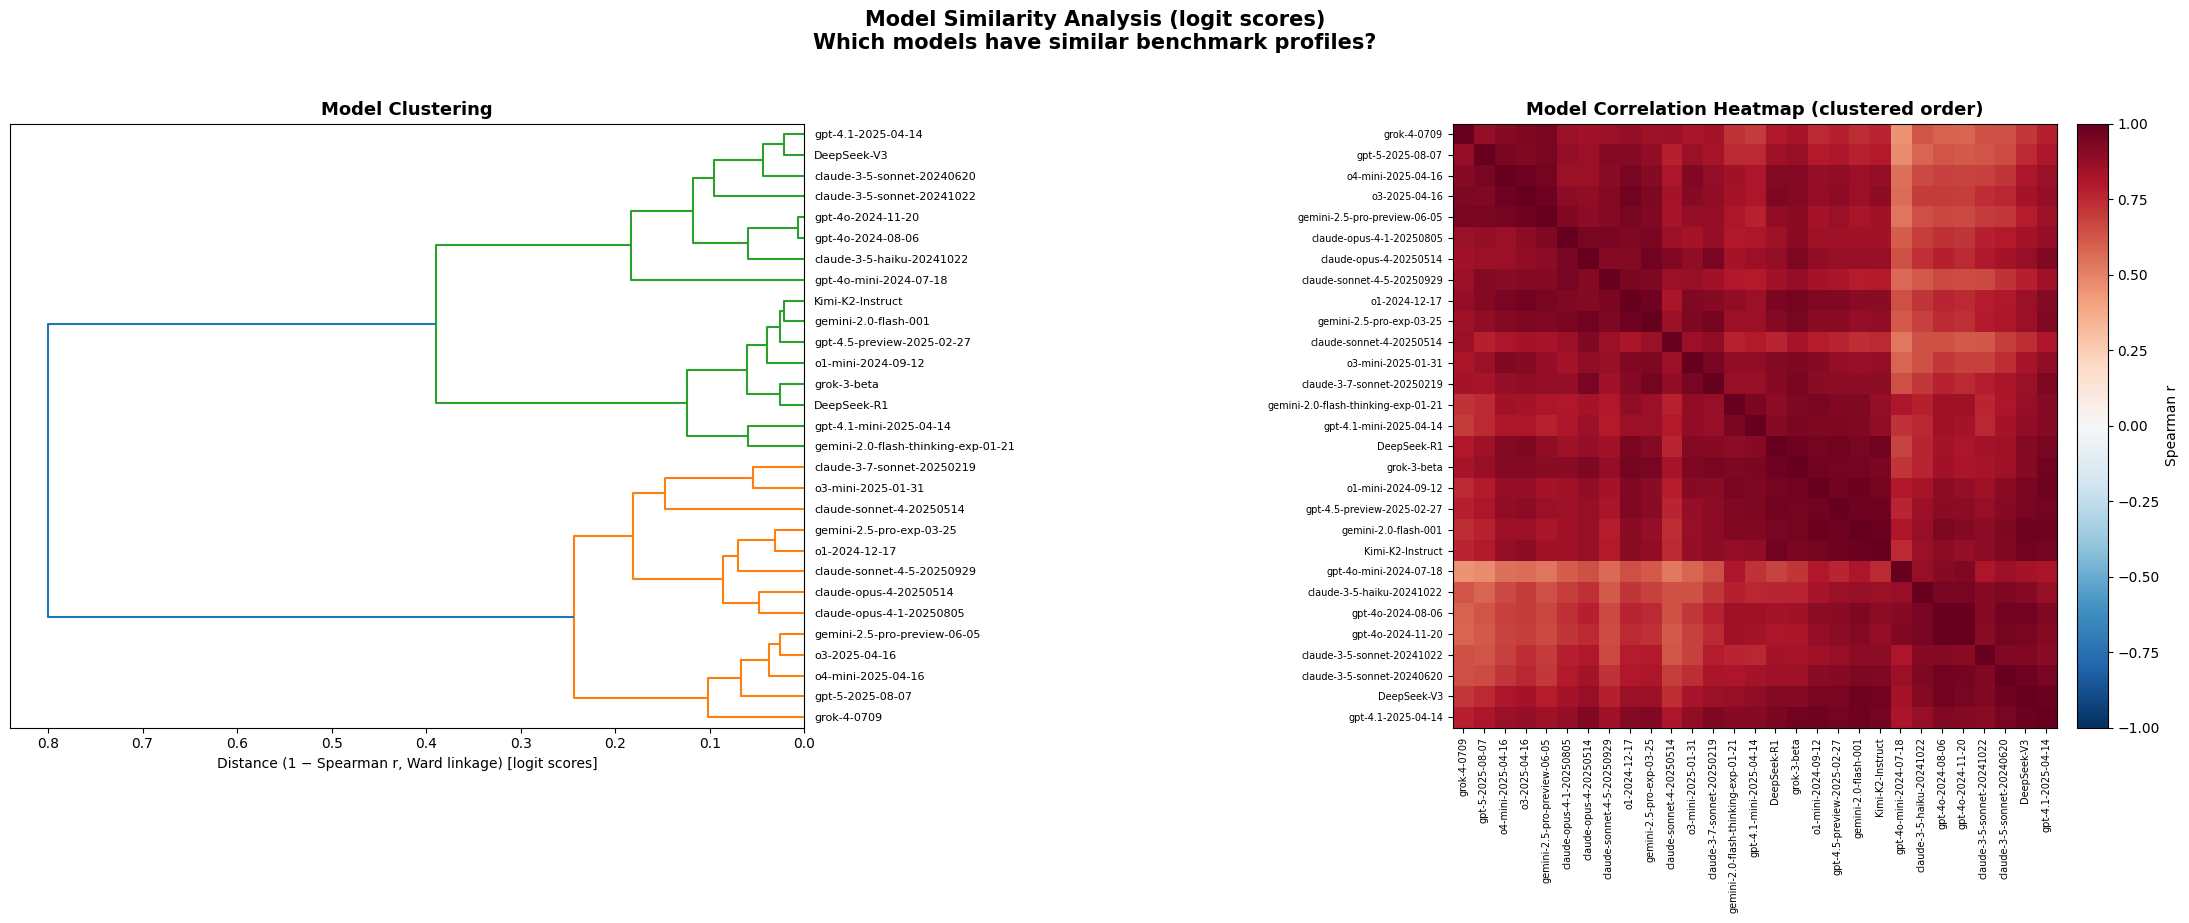


  3 model clusters (Ward linkage)
  Cluster 1 (13 models):
    - o1-2024-12-17
    - o3-2025-04-16
    - o3-mini-2025-01-31
    - o4-mini-2025-04-16
    - claude-3-7-sonnet-20250219
    - claude-opus-4-1-20250805
    - claude-opus-4-20250514
    - claude-sonnet-4-20250514
    - claude-sonnet-4-5-20250929
    - gemini-2.5-pro-exp-03-25
    - gemini-2.5-pro-preview-06-05
    - gpt-5-2025-08-07
    - grok-4-0709
  Cluster 2 (8 models):
    - o1-mini-2024-09-12
    - DeepSeek-R1
    - gemini-2.0-flash-001
    - gemini-2.0-flash-thinking-exp-01-21
    - gpt-4.1-mini-2025-04-14
    - gpt-4.5-preview-2025-02-27
    - grok-3-beta
    - Kimi-K2-Instruct
  Cluster 3 (8 models):
    - claude-3-5-sonnet-20241022
    - DeepSeek-V3
    - gpt-4.1-2025-04-14
    - gpt-4o-2024-08-06
    - gpt-4o-2024-11-20
    - gpt-4o-mini-2024-07-18
    - claude-3-5-haiku-20241022
    - claude-3-5-sonnet-20240620

  5 model clusters (Ward linkage)
  Cluster 1 (5 models):
    - o3-2025-04-16
    - o4-mini-2025-04-16


In [100]:
# === Model Similarity: Hierarchical Clustering ===
# How similar are models to each other across benchmarks?
# Cluster models by the Spearman correlation of their benchmark-score profiles.
# High correlation = two models perform similarly across all benchmarks.

import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform

KNN_K = 5
EPS   = 1e-6
USE_LOGIT_FOR_CORRELATION = True   # True = correlate on logit(score); False = correlate on [0,1] scores
USE_IMPUTATION = True              # False = pairwise complete correlations only (no filled values)
MIN_SHARED_BENCHMARKS = 2          # when USE_IMPUTATION=False, drop models with fewer than this many shared benchmarks with any other model

def expit(z): return 1.0 / (1.0 + np.exp(-z))
def logit(p, eps=EPS):
    p = np.clip(p, eps, 1 - eps)
    return np.log(p / (1 - p))

# --- matrix (imputed or raw with NaNs) ---
M = df_data.pivot_table(index="model_id", columns="benchmark_id", values="performance")
model_names = dict(
    df_data.groupby("model_id")["model"]
    .agg(lambda s: s.dropna().iloc[0] if len(s.dropna()) else str(s.name))
)
bench_names = dict(
    df_data.groupby("benchmark_id")["benchmark"]
    .agg(lambda s: s.dropna().iloc[0] if len(s.dropna()) else str(s.name))
)

X = M.values.astype(float)
X_logit = logit(X)  # NaNs preserved
if USE_IMPUTATION:
    imputer = KNNImputer(n_neighbors=KNN_K, weights="distance")
    X_logit_imp = imputer.fit_transform(X_logit)
    X_imp = expit(X_logit_imp)
    df_imp = pd.DataFrame(X_imp, index=M.index, columns=M.columns)
    df_logit_imp = pd.DataFrame(X_logit_imp, index=M.index, columns=M.columns)
    df_corr = df_logit_imp if USE_LOGIT_FOR_CORRELATION else df_imp
else:
    df_raw = M.astype(float)
    df_logit_raw = pd.DataFrame(X_logit, index=M.index, columns=M.columns)
    df_corr = df_logit_raw if USE_LOGIT_FOR_CORRELATION else df_raw
m_labels = [model_names.get(mid, str(mid)) for mid in M.index]

# --- When no imputation, iteratively drop models until all pairs have enough shared benchmarks ---
if not USE_IMPUTATION:
    dropped = []
    while True:
        notna = df_corr.notna()
        n_models = df_corr.shape[0]
        if n_models < 2:
            break
        shared_counts = np.zeros((n_models, n_models), dtype=int)
        for i in range(n_models):
            for j in range(i, n_models):
                n_shared = (notna.iloc[i, :] & notna.iloc[j, :]).sum()
                shared_counts[i, j] = shared_counts[j, i] = n_shared
        np.fill_diagonal(shared_counts, 999)
        min_per_model = shared_counts.min(axis=1)
        if min_per_model.min() >= MIN_SHARED_BENCHMARKS:
            break
        worst = int(np.argmin(min_per_model))
        dropped.append(m_labels[worst])
        keep = [i for i in range(n_models) if i != worst]
        df_corr = df_corr.iloc[keep, :]
        m_labels = [m_labels[i] for i in keep]
        M = M.iloc[keep, :]
    if dropped:
        print(f"Dropped {len(dropped)} models with < {MIN_SHARED_BENCHMARKS} shared benchmarks:")
        for d in dropped:
            print(f"  - {d}")
    print(f"Models remaining: {len(m_labels)}")

# --- Spearman correlation between models (transpose: correlate rows) ---
R_models = df_corr.T.corr(method="spearman")
n_nan = R_models.isna().sum().sum() if R_models.isna().any().any() else 0
if n_nan:
    print(f"Warning: {n_nan} NaN correlations remaining after filtering. Treating as r=0.")
    R_models = R_models.fillna(0)
R_models.index = m_labels
R_models.columns = m_labels

# --- distance = 1 - r  (not |r|, since model anti-correlation is meaningful) ---
dist_mat = 1 - R_models.values
np.fill_diagonal(dist_mat, 0)
dist_mat = (dist_mat + dist_mat.T) / 2
dist_mat = np.clip(dist_mat, 0, None)

dist_condensed = squareform(dist_mat, checks=False)
Z = linkage(dist_condensed, method="ward")

# --- Figure: dendrogram + heatmap side by side ---
fig, axes = plt.subplots(1, 2, figsize=(22, max(9, len(m_labels) * 0.3)),
                         gridspec_kw={"width_ratios": [1, 1.3]})

# 1 – Dendrogram
ax = axes[0]
dn = dendrogram(Z, labels=m_labels, orientation="left", ax=ax,
                leaf_font_size=8, color_threshold=0.7 * max(Z[:, 2]))
xlabel_suffix = []
if USE_LOGIT_FOR_CORRELATION:
    xlabel_suffix.append("logit scores")
if not USE_IMPUTATION:
    xlabel_suffix.append("no imputation")
ax.set_xlabel("Distance (1 − Spearman r, Ward linkage)" + (" [" + ", ".join(xlabel_suffix) + "]" if xlabel_suffix else ""))
ax.set_title("Model Clustering", fontsize=13, fontweight="bold")

# 2 – Reordered correlation heatmap
ax = axes[1]
order = dn["leaves"]
R_ordered = R_models.values[np.ix_(order, order)]
labels_ordered = [m_labels[i] for i in order]

im = ax.imshow(R_ordered, cmap="RdBu_r", vmin=-1, vmax=1, interpolation="nearest")
plt.colorbar(im, ax=ax, fraction=0.03, pad=0.02, label="Spearman r")
ax.set_xticks(range(len(labels_ordered)))
ax.set_xticklabels(labels_ordered, rotation=90, fontsize=7)
ax.set_yticks(range(len(labels_ordered)))
ax.set_yticklabels(labels_ordered, fontsize=7)
ax.set_title("Model Correlation Heatmap (clustered order)", fontsize=13, fontweight="bold")

subtitle = []
if USE_LOGIT_FOR_CORRELATION:
    subtitle.append("logit scores")
if not USE_IMPUTATION:
    subtitle.append("no imputation")
title = "Model Similarity Analysis" + (" (" + ", ".join(subtitle) + ")" if subtitle else "") + "\nWhich models have similar benchmark profiles?"
fig.suptitle(title, fontsize=15, fontweight="bold", y=1.02)
plt.tight_layout()
plt.show()

# --- Print clusters ---
for n_clust in [3, 5]:
    clusters = fcluster(Z, t=n_clust, criterion="maxclust")
    print(f"\n{'='*55}")
    print(f"  {n_clust} model clusters (Ward linkage)")
    print(f"{'='*55}")
    for c in range(1, n_clust + 1):
        members = [m_labels[i] for i in range(len(m_labels)) if clusters[i] == c]
        print(f"  Cluster {c} ({len(members)} models):")
        for m in members:
            print(f"    - {m}")

# --- Which model pairs are most/least similar? ---
tri = np.triu(np.ones_like(R_models.values, dtype=bool), 1)
pairs = []
for i in range(len(m_labels)):
    for j in range(i+1, len(m_labels)):
        pairs.append((m_labels[i], m_labels[j], R_models.values[i, j]))
pairs.sort(key=lambda x: x[2], reverse=True)

print(f"\n{'='*55}")
print(f"  Most similar model pairs (highest Spearman r)")
print(f"{'='*55}")
for a, b, r in pairs[:10]:
    print(f"  r = {r:.3f}   {a}  ↔  {b}")

print(f"\n{'='*55}")
print(f"  Most different model pairs (lowest Spearman r)")
print(f"{'='*55}")
for a, b, r in pairs[-10:]:
    print(f"  r = {r:.3f}   {a}  ↔  {b}")

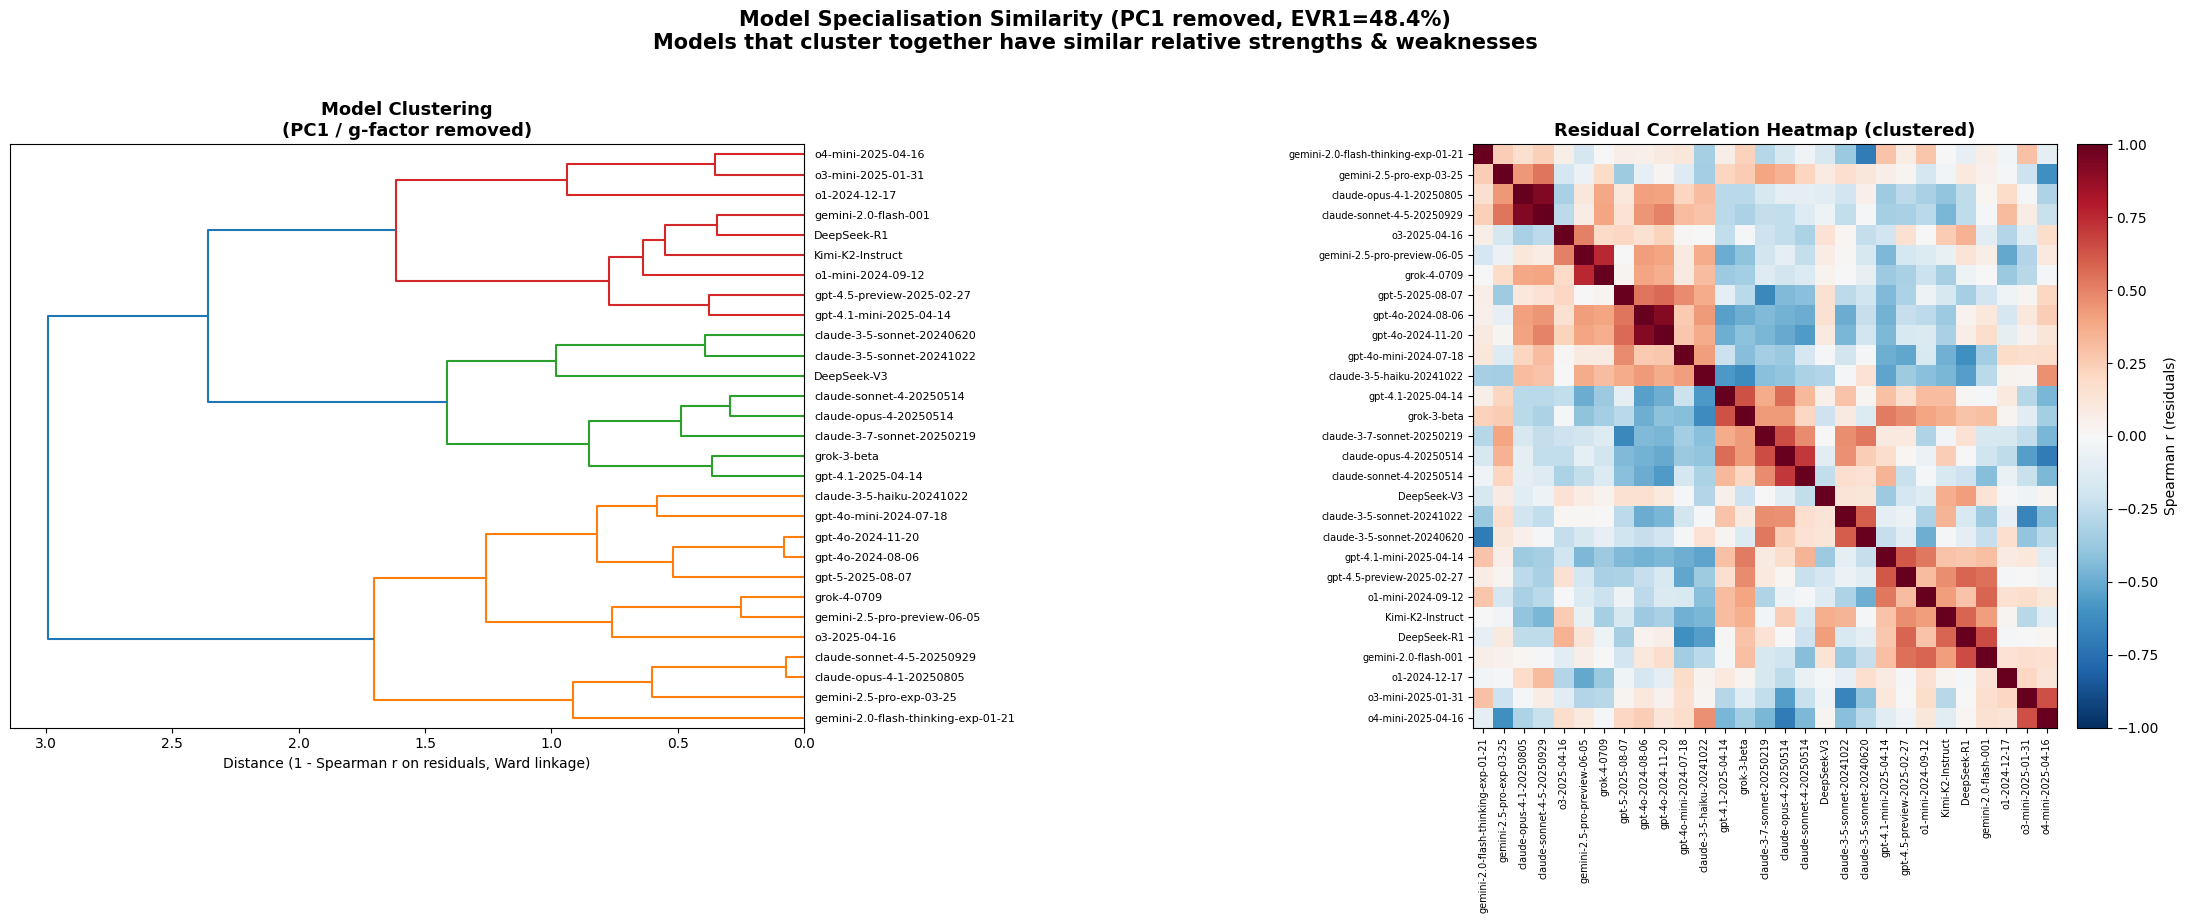


  3 specialisation clusters (PC1 removed, Ward linkage)

  Cluster 1 (12 models):
    - o3-2025-04-16  (PC1=-4.25)
    - claude-opus-4-1-20250805  (PC1=-3.38)
    - claude-sonnet-4-5-20250929  (PC1=-4.39)
    - gemini-2.0-flash-thinking-exp-01-21  (PC1=+2.13)
    - gemini-2.5-pro-exp-03-25  (PC1=-3.54)
    - gemini-2.5-pro-preview-06-05  (PC1=-3.82)
    - gpt-4o-2024-08-06  (PC1=+4.71)
    - gpt-4o-2024-11-20  (PC1=+4.70)
    - gpt-4o-mini-2024-07-18  (PC1=+6.74)
    - gpt-5-2025-08-07  (PC1=-6.65)
    - grok-4-0709  (PC1=-4.28)
    - claude-3-5-haiku-20241022  (PC1=+5.22)
    Shared strengths: VideoMME (+0.61), Fiction.LiveBench (+0.48), Terminal Bench (+0.33)
    Shared weaknesses: Factorio learning environment (-0.71), The Agent Company (-0.55), OSUniverse (-0.38)

  Cluster 2 (8 models):
    - claude-3-5-sonnet-20241022  (PC1=+1.46)
    - claude-3-7-sonnet-20250219  (PC1=-1.50)
    - claude-opus-4-20250514  (PC1=-1.61)
    - claude-sonnet-4-20250514  (PC1=-0.78)
    - DeepSeek-V3 

In [101]:
# === Model Similarity After Removing PC1 (g-factor) ===
# The previous cell clusters models by their FULL benchmark profiles — but
# overall capability (PC1) dominates that signal. A weak model and a strong
# model will always look different, even if their relative strengths are identical.
#
# Here we subtract each model's PC1 reconstruction before computing similarity.
# The result clusters models by their SPECIALISATION PROFILE:
#   "Which models are relatively good/bad at the same things?"

import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform

KNN_K = 5
EPS   = 1e-6

def expit(z): return 1.0 / (1.0 + np.exp(-z))
def logit(p, eps=EPS):
    p = np.clip(p, eps, 1 - eps)
    return np.log(p / (1 - p))

# --- imputed, standardised matrix ---
Mr = df_data.pivot_table(index="model_id", columns="benchmark_id", values="performance")
model_names_r = dict(
    df_data.groupby("model_id")["model"]
    .agg(lambda s: s.dropna().iloc[0] if len(s.dropna()) else str(s.name))
)

Xr = Mr.values.astype(float)
Xr_logit = logit(Xr)
imp_r = KNNImputer(n_neighbors=KNN_K, weights="distance")
Xr_logit_imp = imp_r.fit_transform(Xr_logit)
Xr_imp = expit(Xr_logit_imp)

cm_r = Xr_imp.mean(axis=0)
cs_r = Xr_imp.std(axis=0, ddof=1); cs_r[cs_r == 0] = 1.0
Xz_r = (Xr_imp - cm_r) / cs_r

# --- PCA: remove PC1 ---
pca_r = PCA().fit(Xz_r)
scores_r = pca_r.transform(Xz_r)
evr1_r = pca_r.explained_variance_ratio_[0]

pc1_reconstruction = np.outer(scores_r[:, 0], pca_r.components_[0])
residuals_r = Xz_r - pc1_reconstruction

m_labels_r = [model_names_r.get(mid, str(mid)) for mid in Mr.index]

# --- Spearman correlation on residuals ---
df_resid_corr = pd.DataFrame(residuals_r, index=Mr.index, columns=Mr.columns)
R_resid = df_resid_corr.T.corr(method="spearman")
R_resid.index = m_labels_r
R_resid.columns = m_labels_r

# --- distance and clustering ---
dist_resid = 1 - R_resid.values
np.fill_diagonal(dist_resid, 0)
dist_resid = (dist_resid + dist_resid.T) / 2
dist_resid = np.clip(dist_resid, 0, None)

dist_cond_r = squareform(dist_resid, checks=False)
Z_r = linkage(dist_cond_r, method="ward")

# --- Figure: dendrogram + heatmap ---
fig, axes = plt.subplots(1, 2, figsize=(22, max(9, len(m_labels_r) * 0.3)),
                         gridspec_kw={"width_ratios": [1, 1.3]})

ax = axes[0]
dn_r = dendrogram(Z_r, labels=m_labels_r, orientation="left", ax=ax,
                  leaf_font_size=8, color_threshold=0.7 * max(Z_r[:, 2]))
ax.set_xlabel("Distance (1 - Spearman r on residuals, Ward linkage)")
ax.set_title("Model Clustering\n(PC1 / g-factor removed)", fontsize=13, fontweight="bold")

ax = axes[1]
order_r = dn_r["leaves"]
R_ordered_r = R_resid.values[np.ix_(order_r, order_r)]
labels_ordered_r = [m_labels_r[i] for i in order_r]

im = ax.imshow(R_ordered_r, cmap="RdBu_r", vmin=-1, vmax=1, interpolation="nearest")
plt.colorbar(im, ax=ax, fraction=0.03, pad=0.02, label="Spearman r (residuals)")
ax.set_xticks(range(len(labels_ordered_r)))
ax.set_xticklabels(labels_ordered_r, rotation=90, fontsize=7)
ax.set_yticks(range(len(labels_ordered_r)))
ax.set_yticklabels(labels_ordered_r, fontsize=7)
ax.set_title("Residual Correlation Heatmap (clustered)", fontsize=13, fontweight="bold")

fig.suptitle(f"Model Specialisation Similarity (PC1 removed, EVR1={evr1_r:.1%})\n"
             "Models that cluster together have similar relative strengths & weaknesses",
             fontsize=15, fontweight="bold", y=1.02)
plt.tight_layout()
plt.show()

# --- Print clusters ---
for n_clust in [3, 5]:
    clusters_r = fcluster(Z_r, t=n_clust, criterion="maxclust")
    print(f"\n{'='*60}")
    print(f"  {n_clust} specialisation clusters (PC1 removed, Ward linkage)")
    print(f"{'='*60}")

    # for each cluster, show the top shared strengths/weaknesses
    bench_names_r = dict(
        df_data.groupby("benchmark_id")["benchmark"]
        .agg(lambda s: s.dropna().iloc[0] if len(s.dropna()) else str(s.name))
    )
    b_labs_r = [bench_names_r.get(bid, str(bid)) for bid in Mr.columns]
    df_resid_named = pd.DataFrame(residuals_r, index=m_labels_r, columns=b_labs_r)

    for c in range(1, n_clust + 1):
        members = [m_labels_r[i] for i in range(len(m_labels_r)) if clusters_r[i] == c]
        mean_profile = df_resid_named.loc[members].mean()
        top_strengths = mean_profile.nlargest(3)
        top_weaknesses = mean_profile.nsmallest(3)
        print(f"\n  Cluster {c} ({len(members)} models):")
        for m in members:
            pc1_score = scores_r[m_labels_r.index(m), 0]
            print(f"    - {m}  (PC1={pc1_score:+.2f})")
        strengths_str = ", ".join([f"{b} (+{v:.2f})" for b, v in top_strengths.items()])
        weaknesses_str = ", ".join([f"{b} ({v:.2f})" for b, v in top_weaknesses.items()])
        print(f"    Shared strengths: {strengths_str}")
        print(f"    Shared weaknesses: {weaknesses_str}")

# --- Most/least similar specialisation pairs ---
tri_r = np.triu(np.ones_like(R_resid.values, dtype=bool), 1)
pairs_r = []
for i in range(len(m_labels_r)):
    for j in range(i + 1, len(m_labels_r)):
        pairs_r.append((m_labels_r[i], m_labels_r[j], R_resid.values[i, j]))
pairs_r.sort(key=lambda x: x[2], reverse=True)

print(f"\n{'='*60}")
print(f"  Most similar SPECIALISATION profiles (after removing g)")
print(f"{'='*60}")
for a, b, r in pairs_r[:10]:
    print(f"  r = {r:.3f}   {a}  <->  {b}")

print(f"\n{'='*60}")
print(f"  Most OPPOSITE specialisation profiles")
print(f"{'='*60}")
for a, b, r in pairs_r[-10:]:
    print(f"  r = {r:.3f}   {a}  <->  {b}")


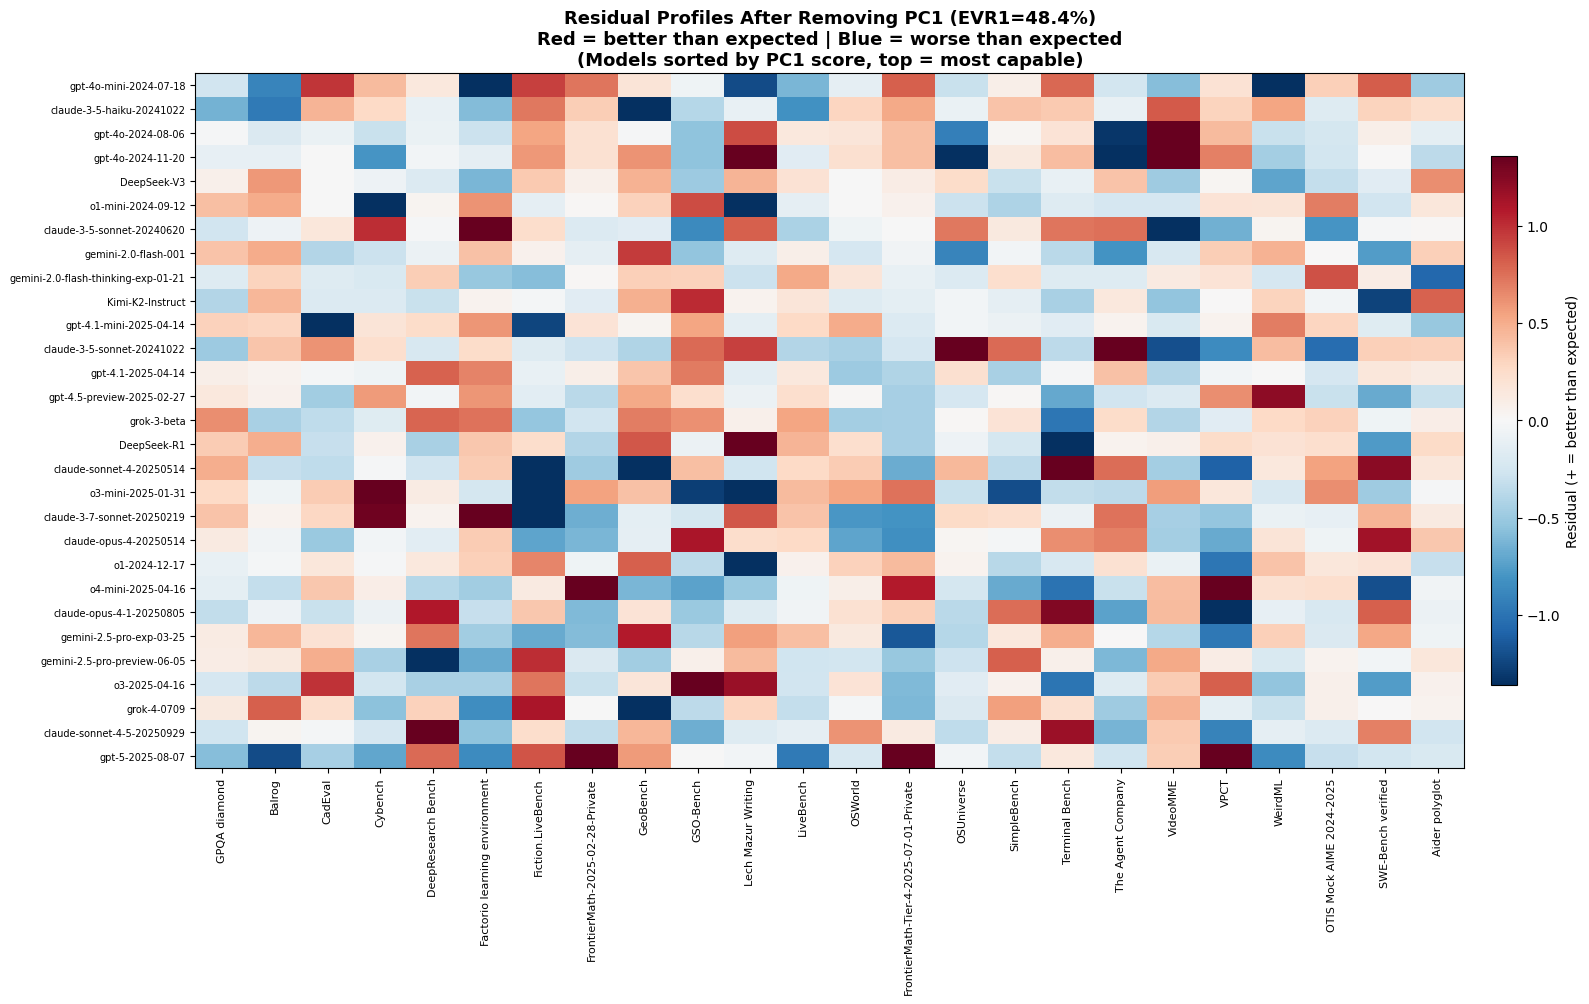

  Top specialisations per model (biggest + and − residuals)

  gpt-4o-mini-2024-07-18
    Strengths:  CadEval (+0.97), Fiction.LiveBench (+0.93), SWE-Bench verified (+0.83)
    Weaknesses: Factorio learning environment (-2.82), WeirdML (-1.39), Lech Mazur Writing (-1.21)

  claude-3-5-haiku-20241022
    Strengths:  VideoMME (+0.83), Fiction.LiveBench (+0.71), WeirdML (+0.54)
    Weaknesses: GeoBench (-2.50), Balrog (-0.96), LiveBench (-0.82)

  gpt-4o-2024-08-06
    Strengths:  VideoMME (+3.19), Lech Mazur Writing (+0.89), Fiction.LiveBench (+0.54)
    Weaknesses: The Agent Company (-1.32), OSUniverse (-0.93), GSO-Bench (-0.54)

  gpt-4o-2024-11-20
    Strengths:  VideoMME (+1.66), Lech Mazur Writing (+1.49), VPCT (+0.68)
    Weaknesses: The Agent Company (-1.87), OSUniverse (-1.36), Cybench (-0.80)

  DeepSeek-V3
    Strengths:  Aider polyglot (+0.63), Balrog (+0.59), GeoBench (+0.47)
    Weaknesses: WeirdML (-0.71), Factorio learning environment (-0.62), GSO-Bench (-0.50)

  o1-mini-

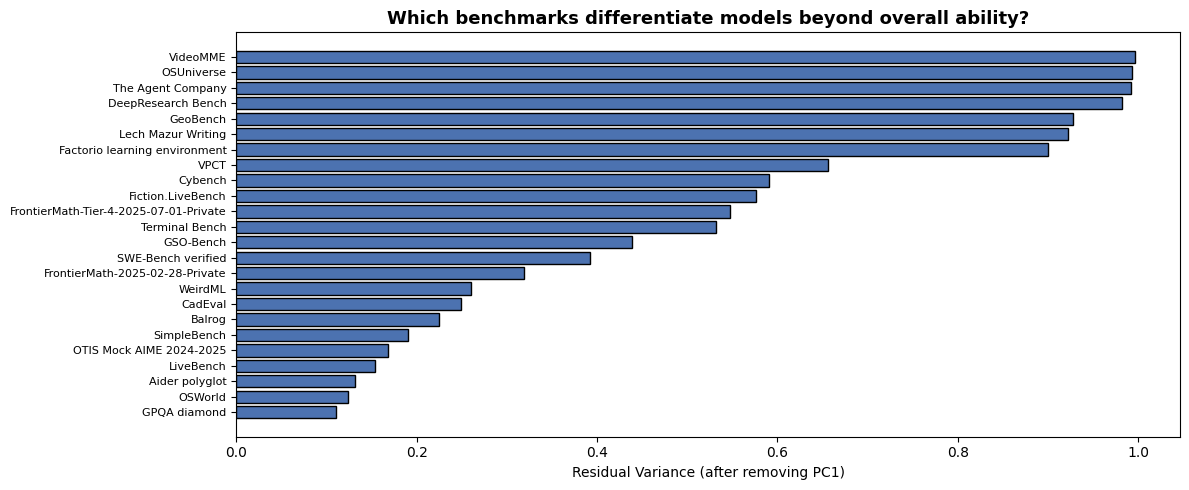


Benchmarks with most residual variance (most discriminating beyond g):
  VideoMME: 0.9968
  OSUniverse: 0.9938
  The Agent Company: 0.9928
  DeepResearch Bench: 0.9818
  GeoBench: 0.9281
  Lech Mazur Writing: 0.9229
  Factorio learning environment: 0.9004
  VPCT: 0.6563

Benchmarks with least residual variance (most redundant with g):
  OTIS Mock AIME 2024-2025: 0.1683
  LiveBench: 0.1533
  Aider polyglot: 0.1315
  OSWorld: 0.1243
  GPQA diamond: 0.1100


In [102]:
# === Residual Profiles: What makes each model special? ===
# Remove PC1 (the "g-factor") and look at what's left.
# Positive residual = model is surprisingly GOOD at that benchmark given its overall ability.
# Negative residual = model is surprisingly BAD.

import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer

KNN_K = 5
EPS   = 1e-6

def expit(z): return 1.0 / (1.0 + np.exp(-z))
def logit(p, eps=EPS):
    p = np.clip(p, eps, 1 - eps)
    return np.log(p / (1 - p))

# --- imputed, standardized matrix ---
M = df_data.pivot_table(index="model_id", columns="benchmark_id", values="performance")
model_names = dict(
    df_data.groupby("model_id")["model"]
    .agg(lambda s: s.dropna().iloc[0] if len(s.dropna()) else str(s.name))
)
bench_names = dict(
    df_data.groupby("benchmark_id")["benchmark"]
    .agg(lambda s: s.dropna().iloc[0] if len(s.dropna()) else str(s.name))
)

X = M.values.astype(float)
X_logit = logit(X)
imputer = KNNImputer(n_neighbors=KNN_K, weights="distance")
X_logit_imp = imputer.fit_transform(X_logit)
X_imp = expit(X_logit_imp)

cm = X_imp.mean(axis=0)
cs = X_imp.std(axis=0, ddof=1); cs[cs == 0] = 1.0
Xz = (X_imp - cm) / cs

# --- PCA & residuals ---
pca = PCA().fit(Xz)
scores = pca.transform(Xz)
evr1 = pca.explained_variance_ratio_[0]

# Reconstruct from PC1 only, then subtract to get residuals
pc1_reconstruction = np.outer(scores[:, 0], pca.components_[0])
residuals = Xz - pc1_reconstruction

m_labels = [model_names.get(mid, str(mid)) for mid in M.index]
b_labels = [bench_names.get(bid, str(bid)) for bid in M.columns]

df_resid = pd.DataFrame(residuals, index=m_labels, columns=b_labels)

# --- sort models by PC1 score (overall ability) ---
pc1_order = np.argsort(scores[:, 0])[::-1]
df_resid = df_resid.iloc[pc1_order]

# --- Figure 1: full heatmap ---
fig, ax = plt.subplots(figsize=(16, max(8, len(m_labels) * 0.35)))
vabs = np.percentile(np.abs(residuals), 95)
im = ax.imshow(df_resid.values, cmap="RdBu_r", vmin=-vabs, vmax=vabs,
               aspect="auto", interpolation="nearest")
plt.colorbar(im, ax=ax, fraction=0.02, pad=0.02,
             label="Residual (+ = better than expected)")

ax.set_xticks(range(len(b_labels)))
ax.set_xticklabels(df_resid.columns, rotation=90, fontsize=8)
ax.set_yticks(range(len(df_resid)))
ax.set_yticklabels(df_resid.index, fontsize=7)
ax.set_title(f"Residual Profiles After Removing PC1 (EVR1={evr1:.1%})\n"
             "Red = better than expected | Blue = worse than expected\n"
             "(Models sorted by PC1 score, top = most capable)",
             fontsize=13, fontweight="bold")
plt.tight_layout()
plt.show()

# --- Figure 2: top specialisations per model ---
print("=" * 60)
print("  Top specialisations per model (biggest + and − residuals)")
print("=" * 60)

for i in range(len(df_resid)):
    row = df_resid.iloc[i]
    top_pos = row.nlargest(3)
    top_neg = row.nsmallest(3)
    name = df_resid.index[i]
    strengths = ", ".join([f"{b} (+{v:.2f})" for b, v in top_pos.items()])
    weaknesses = ", ".join([f"{b} ({v:.2f})" for b, v in top_neg.items()])
    print(f"\n  {name}")
    print(f"    Strengths:  {strengths}")
    print(f"    Weaknesses: {weaknesses}")

# --- Figure 3: which benchmarks have the most residual variance? ---
resid_var = df_resid.var().sort_values(ascending=False)
fig, ax = plt.subplots(figsize=(12, 5))
ax.barh(range(len(resid_var)), resid_var.values, color="#4C72B0", edgecolor="black")
ax.set_yticks(range(len(resid_var)))
ax.set_yticklabels(resid_var.index, fontsize=8)
ax.invert_yaxis()
ax.set_xlabel("Residual Variance (after removing PC1)")
ax.set_title("Which benchmarks differentiate models beyond overall ability?",
             fontsize=13, fontweight="bold")
plt.tight_layout()
plt.show()

print(f"\nBenchmarks with most residual variance (most discriminating beyond g):")
for b, v in resid_var.head(8).items():
    print(f"  {b}: {v:.4f}")
print(f"\nBenchmarks with least residual variance (most redundant with g):")
for b, v in resid_var.tail(5).items():
    print(f"  {b}: {v:.4f}")

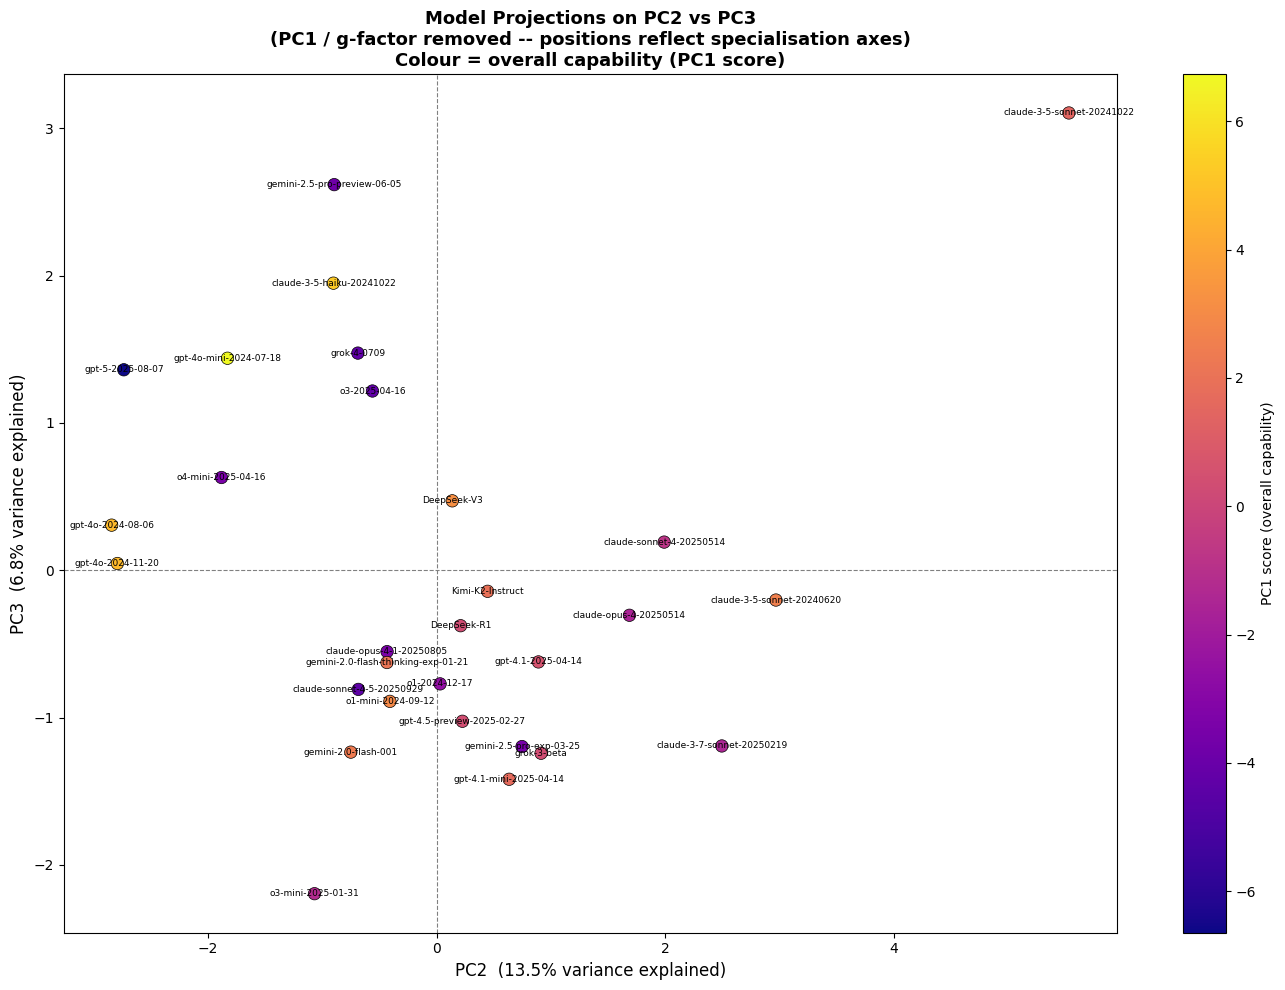

PC1: 48.4% | PC2: 13.5% | PC3: 6.8% variance explained


In [103]:
# === Model Projections: PC2 vs PC3 ===
# PC1 captures overall ability (g-factor). PC2 and PC3 reveal specialisation axes.
# Models close together in PC2-PC3 space have similar specialisation profiles
# independent of their overall capability level.

import numpy as np, matplotlib.pyplot as plt, matplotlib.cm as cm
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer

KNN_K = 5
EPS   = 1e-6

def expit(z): return 1.0 / (1.0 + np.exp(-z))
def logit(p, eps=EPS):
    p = np.clip(p, eps, 1 - eps)
    return np.log(p / (1 - p))

# --- build imputed, standardised matrix (same pipeline as cell 4) ---
M2 = df_data.pivot_table(index="model_id", columns="benchmark_id", values="performance")
model_names2 = dict(
    df_data.groupby("model_id")["model"]
    .agg(lambda s: s.dropna().iloc[0] if len(s.dropna()) else str(s.name))
)
bench_names2 = dict(
    df_data.groupby("benchmark_id")["benchmark"]
    .agg(lambda s: s.dropna().iloc[0] if len(s.dropna()) else str(s.name))
)

X2 = M2.values.astype(float)
X2_logit = logit(X2)
imputer2 = KNNImputer(n_neighbors=KNN_K, weights="distance")
X2_logit_imp = imputer2.fit_transform(X2_logit)
X2_imp = expit(X2_logit_imp)

cm_col = X2_imp.mean(axis=0)
cs_col = X2_imp.std(axis=0, ddof=1); cs_col[cs_col == 0] = 1.0
Xz2 = (X2_imp - cm_col) / cs_col

pca2 = PCA(n_components=min(10, Xz2.shape[1])).fit(Xz2)
scores2 = pca2.transform(Xz2)
evr = pca2.explained_variance_ratio_

m_labels2 = [model_names2.get(mid, str(mid)) for mid in M2.index]
b_labels2  = [bench_names2.get(bid, str(bid)) for bid in M2.columns]

# colour by PC1 score (overall capability)
pc1_vals = scores2[:, 0]

fig, ax = plt.subplots(figsize=(14, 10))
sc = ax.scatter(scores2[:, 1], scores2[:, 2], c=pc1_vals, cmap="plasma",
                s=80, edgecolors="k", linewidths=0.5, zorder=3)
plt.colorbar(sc, ax=ax, label="PC1 score (overall capability)")

ax.axhline(0, color="gray", lw=0.8, ls="--", zorder=1)
ax.axvline(0, color="gray", lw=0.8, ls="--", zorder=1)

texts = []
for i, lbl in enumerate(m_labels2):
    texts.append(ax.text(scores2[i, 1], scores2[i, 2], lbl, fontsize=6.5,
                         ha="center", va="center"))

try:
    from adjustText import adjust_text
    adjust_text(texts, ax=ax, arrowprops=dict(arrowstyle="-", color="gray", lw=0.4))
except ImportError:
    pass  # adjustText not installed -- labels may overlap

ax.set_xlabel("PC2  (" + f"{evr[1]:.1%}" + " variance explained)", fontsize=12)
ax.set_ylabel("PC3  (" + f"{evr[2]:.1%}" + " variance explained)", fontsize=12)
title = ("Model Projections on PC2 vs PC3\n"
         "(PC1 / g-factor removed -- positions reflect specialisation axes)\n"
         "Colour = overall capability (PC1 score)")
ax.set_title(title, fontsize=13, fontweight="bold")
plt.tight_layout()
plt.show()

print("PC1:", f"{evr[0]:.1%}", "| PC2:", f"{evr[1]:.1%}", "| PC3:", f"{evr[2]:.1%}", "variance explained")


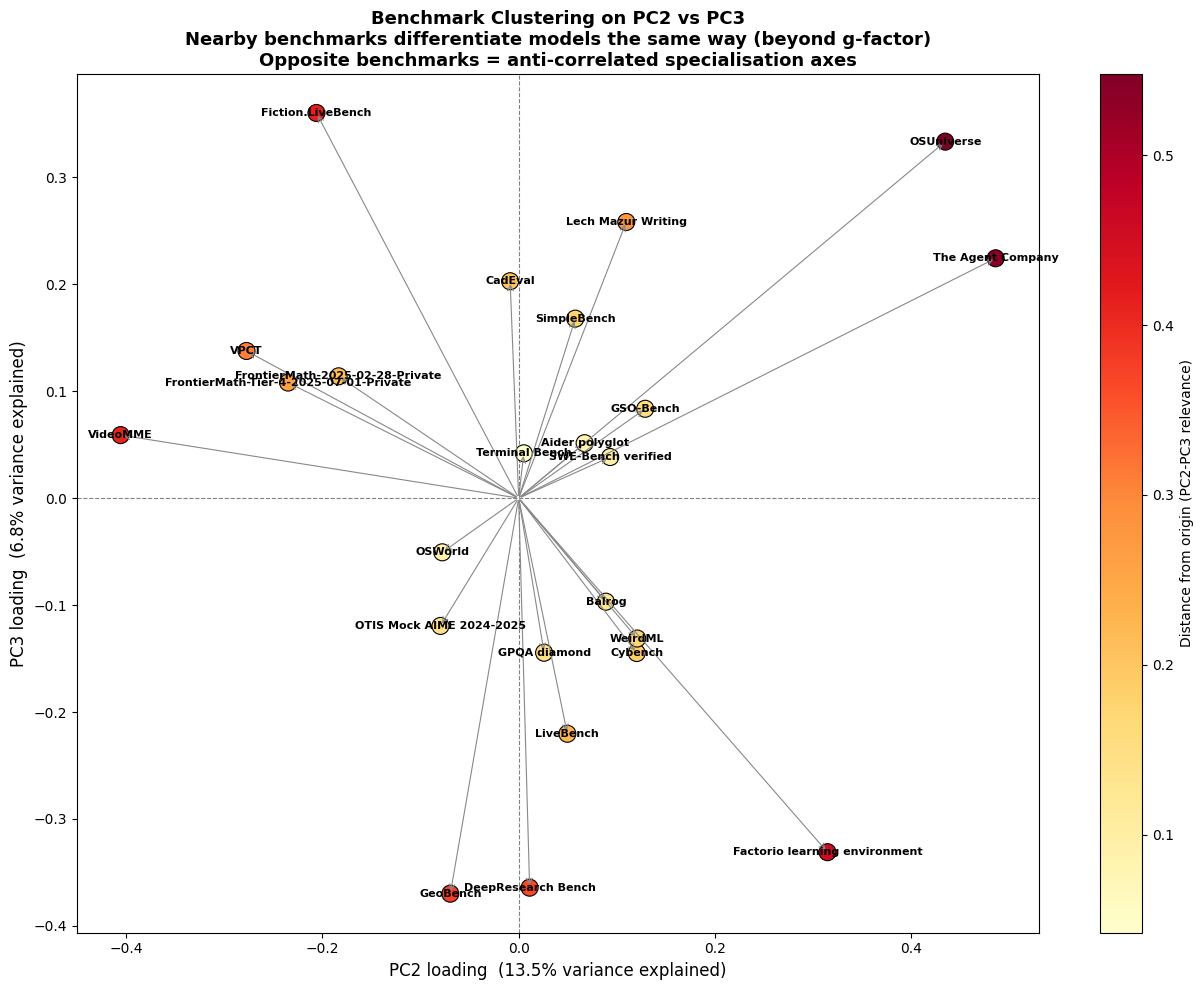


Benchmark PC2 / PC3 loadings (sorted by PC2 descending):
-----------------------------------------------------------------
  Benchmark                            PC2 loading   PC3 loading
-----------------------------------------------------------------
  The Agent Company                       +0.4861       +0.2243
  OSUniverse                              +0.4347       +0.3334
  Factorio learning environment           +0.3147       -0.3311
  GSO-Bench                               +0.1290       +0.0836
  WeirdML                                 +0.1208       -0.1313
  Cybench                                 +0.1203       -0.1448
  Lech Mazur Writing                      +0.1097       +0.2582
  SWE-Bench verified                      +0.0932       +0.0384
  Balrog                                  +0.0888       -0.0968
  Aider polyglot                          +0.0672       +0.0514
  SimpleBench                             +0.0577       +0.1679
  LiveBench                              

In [104]:
# === Benchmark Loadings: PC2 vs PC3 ===
# PCA loadings tell us how each benchmark aligns with each PC.
# Benchmarks close together have similar loading patterns -- they differentiate
# models in the same direction beyond overall capability (PC1).
# Benchmarks far apart measure distinct specialisation dimensions.
#
# NOTE: Run the previous cell first (defines pca2, b_labels2, evr).

loadings = pca2.components_    # shape: (n_components, n_benchmarks)
load_pc2 = loadings[1]         # PC2 loadings per benchmark
load_pc3 = loadings[2]         # PC3 loadings per benchmark

# colour by distance from origin (relevance to PC2/PC3 dimensions)
magnitude = np.sqrt(load_pc2**2 + load_pc3**2)

fig, ax = plt.subplots(figsize=(13, 10))
sc = ax.scatter(load_pc2, load_pc3, c=magnitude, cmap="YlOrRd",
                s=150, edgecolors="k", linewidths=0.8, zorder=3)
plt.colorbar(sc, ax=ax, label="Distance from origin (PC2-PC3 relevance)")

ax.axhline(0, color="gray", lw=0.8, ls="--", zorder=1)
ax.axvline(0, color="gray", lw=0.8, ls="--", zorder=1)

# arrows from origin to each benchmark
for lx, ly in zip(load_pc2, load_pc3):
    ax.annotate("", xy=(lx, ly), xytext=(0, 0),
                arrowprops=dict(arrowstyle="->", color="#888888", lw=0.8))

texts_b = []
for i, lbl in enumerate(b_labels2):
    texts_b.append(
        ax.text(load_pc2[i], load_pc3[i], lbl, fontsize=8, fontweight="bold",
                ha="center", va="center")
    )

try:
    from adjustText import adjust_text
    adjust_text(texts_b, ax=ax, arrowprops=dict(arrowstyle="-", color="#aaaaaa", lw=0.5))
except ImportError:
    pass

ax.set_xlabel("PC2 loading  (" + f"{evr[1]:.1%}" + " variance explained)", fontsize=12)
ax.set_ylabel("PC3 loading  (" + f"{evr[2]:.1%}" + " variance explained)", fontsize=12)
title = ("Benchmark Clustering on PC2 vs PC3\n"
         "Nearby benchmarks differentiate models the same way (beyond g-factor)\n"
         "Opposite benchmarks = anti-correlated specialisation axes")
ax.set_title(title, fontsize=13, fontweight="bold")
plt.tight_layout()
plt.show()

# --- tabular summary ---
order = np.argsort(load_pc2)[::-1]
print("\nBenchmark PC2 / PC3 loadings (sorted by PC2 descending):")
print("-" * 65)
print("  " + "Benchmark".ljust(35) + "  PC2 loading   PC3 loading")
print("-" * 65)
for i in order:
    name_col = b_labels2[i][:35].ljust(35)
    print("  " + name_col + "  " + f"{load_pc2[i]:>+10.4f}" + "    " + f"{load_pc3[i]:>+10.4f}")


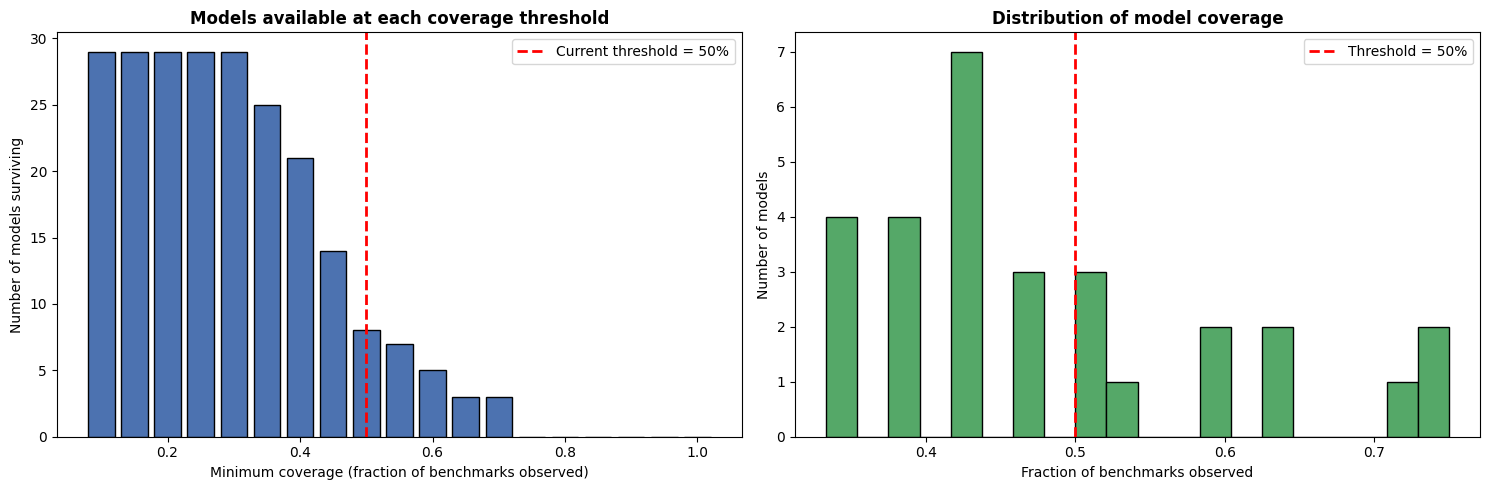

Coverage threshold: 50%
Models surviving: 11 / 29
Benchmarks kept: 19 / 24
Remaining missing fraction: 27.8%



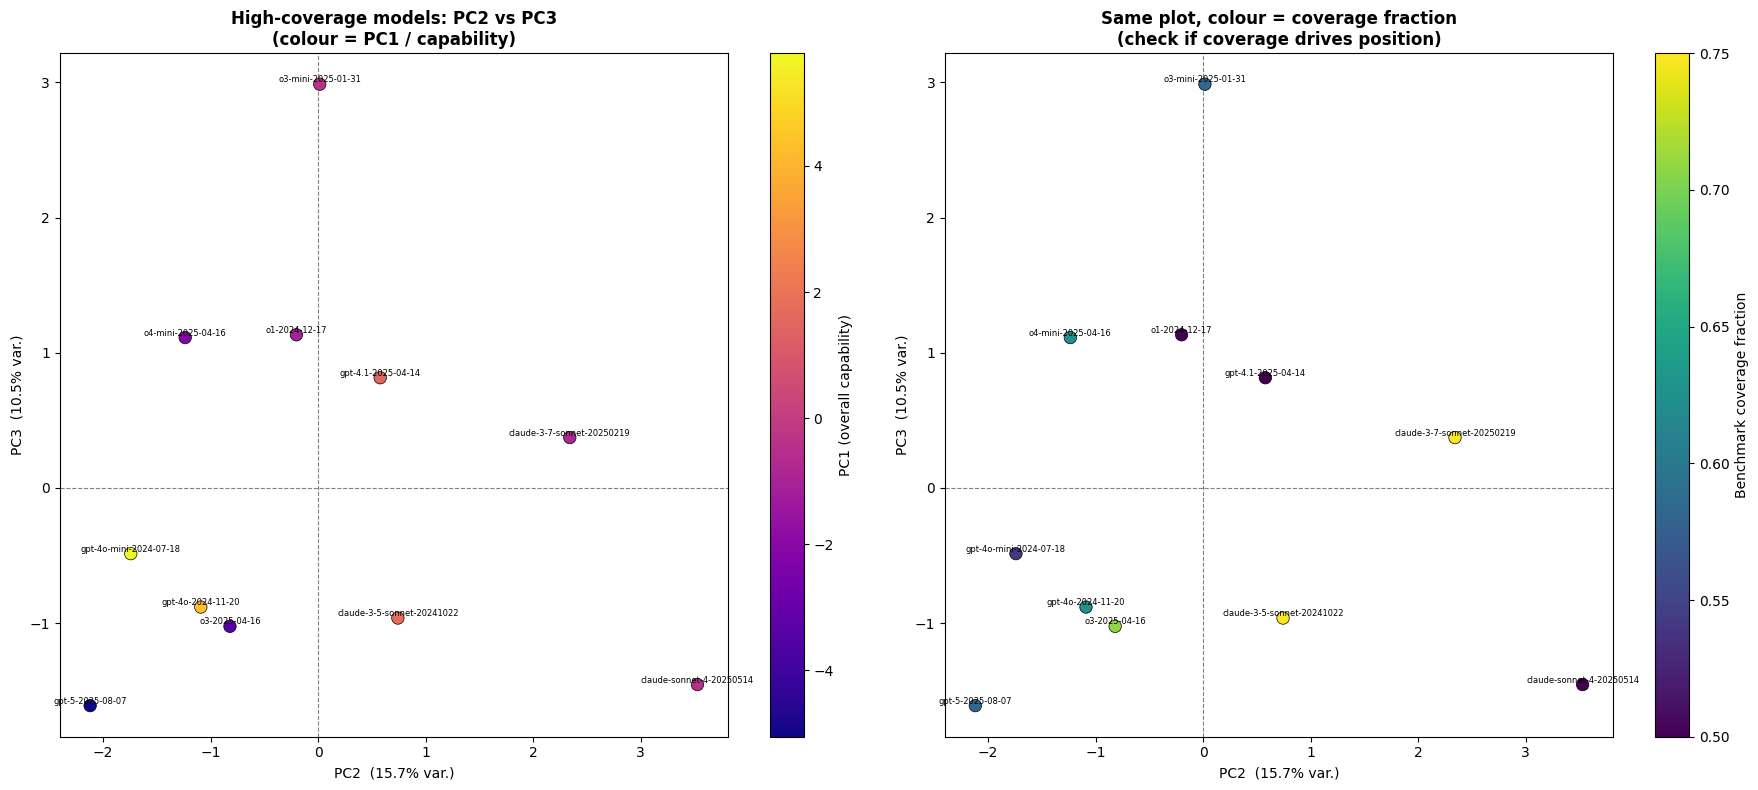

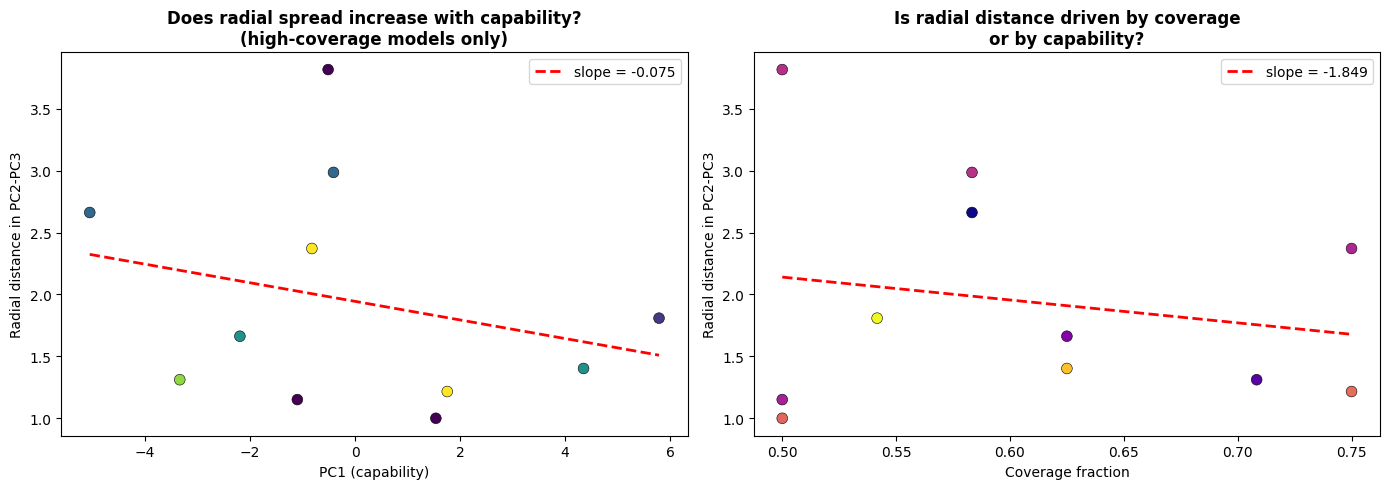

Radial distance vs PC1 (capability):  r = -0.266, p = 0.4298
Radial distance vs coverage fraction:  r = -0.196, p = 0.5633

Neither predictor is clearly dominant. Results are ambiguous.

Variance explained (high-coverage subset):
  PC1: 53.6%
  PC2: 15.7%
  PC3: 10.5%
  PC4: 9.2%
  PC5: 4.0%


In [105]:
# === Imputation Confound Diagnostic: Complete-Cases Analysis ===
# Concern: Less capable models have more missing benchmarks. KNN imputation
# fills gaps with smooth neighbor-averages, artificially inflating EVR1.
# This cell tests whether the PC2-PC3 radial spread pattern survives
# when we restrict to models with high benchmark coverage (minimal imputation).

import numpy as np, matplotlib.pyplot as plt, matplotlib.cm as cm
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer

# ---- KNOB: adjust this threshold ----
MIN_COVERAGE = 0.50   # fraction of benchmarks a model must have observed scores for

KNN_K = 5
EPS   = 1e-6

def expit(z): return 1.0 / (1.0 + np.exp(-z))
def logit(p, eps=EPS):
    p = np.clip(p, eps, 1 - eps)
    return np.log(p / (1 - p))

# --- pivot and compute coverage ---
M_all = df_data.pivot_table(index="model_id", columns="benchmark_id", values="performance")
n_benchmarks_total = M_all.shape[1]

model_coverage = M_all.notna().sum(axis=1) / n_benchmarks_total
bench_coverage = M_all.notna().sum(axis=0) / M_all.shape[0]

model_names_d = dict(
    df_data.groupby("model_id")["model"]
    .agg(lambda s: s.dropna().iloc[0] if len(s.dropna()) else str(s.name))
)

# =============================================
# Figure 0: Coverage landscape — what's available?
# =============================================
thresholds = np.arange(0.1, 1.01, 0.05)
models_at_thresh = [int((model_coverage >= t).sum()) for t in thresholds]

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Left: how many models survive at each threshold
axes[0].bar(thresholds, models_at_thresh, width=0.04, color="#4C72B0", edgecolor="black")
axes[0].axvline(MIN_COVERAGE, color="red", lw=2, ls="--", label=f"Current threshold = {MIN_COVERAGE:.0%}")
axes[0].set_xlabel("Minimum coverage (fraction of benchmarks observed)")
axes[0].set_ylabel("Number of models surviving")
axes[0].set_title("Models available at each coverage threshold", fontweight="bold")
axes[0].legend()

# Right: histogram of per-model coverage
axes[1].hist(model_coverage.values, bins=20, color="#55A868", edgecolor="black")
axes[1].axvline(MIN_COVERAGE, color="red", lw=2, ls="--", label=f"Threshold = {MIN_COVERAGE:.0%}")
axes[1].set_xlabel("Fraction of benchmarks observed")
axes[1].set_ylabel("Number of models")
axes[1].set_title("Distribution of model coverage", fontweight="bold")
axes[1].legend()
plt.tight_layout()
plt.show()

# =============================================
# Filter to high-coverage models
# =============================================
keep_models = model_coverage[model_coverage >= MIN_COVERAGE].index
M_hc = M_all.loc[keep_models]

# Also drop benchmarks that now have zero variance or all-NaN
bench_obs = M_hc.notna().sum(axis=0)
keep_benchmarks = bench_obs[bench_obs >= 3].index
M_hc = M_hc[keep_benchmarks]

n_models_hc = M_hc.shape[0]
n_bench_hc = M_hc.shape[1]
imputed_frac = M_hc.isna().sum().sum() / (n_models_hc * n_bench_hc)

print(f"Coverage threshold: {MIN_COVERAGE:.0%}")
print(f"Models surviving: {n_models_hc} / {M_all.shape[0]}")
print(f"Benchmarks kept: {n_bench_hc} / {n_benchmarks_total}")
print(f"Remaining missing fraction: {imputed_frac:.1%}")
print()

if n_models_hc < 10:
    print("WARNING: Too few models survive this threshold for meaningful PCA.")
    print("Try lowering MIN_COVERAGE.")
else:
    # --- same pipeline: logit -> KNN -> expit -> z-score -> PCA ---
    X_hc = M_hc.values.astype(float)
    X_hc_logit = logit(X_hc)
    imp_hc = KNNImputer(n_neighbors=min(KNN_K, n_models_hc - 1), weights="distance")
    X_hc_logit_imp = imp_hc.fit_transform(X_hc_logit)
    X_hc_imp = expit(X_hc_logit_imp)

    cm_c = X_hc_imp.mean(axis=0)
    cs_c = X_hc_imp.std(axis=0, ddof=1); cs_c[cs_c == 0] = 1.0
    Xz_hc = (X_hc_imp - cm_c) / cs_c

    n_comp = min(10, Xz_hc.shape[1], Xz_hc.shape[0])
    pca_hc = PCA(n_components=n_comp).fit(Xz_hc)
    scores_hc = pca_hc.transform(Xz_hc)
    evr_hc = pca_hc.explained_variance_ratio_

    m_labels_hc = [model_names_d.get(mid, str(mid)) for mid in M_hc.index]
    pc1_hc = scores_hc[:, 0]
    coverage_vals = model_coverage.loc[keep_models].values

    # =============================================
    # Figure 1: PC2 vs PC3 for high-coverage models
    # =============================================
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))

    # Left: colour by PC1
    sc1 = axes[0].scatter(scores_hc[:, 1], scores_hc[:, 2], c=pc1_hc, cmap="plasma",
                          s=80, edgecolors="k", linewidths=0.5, zorder=3)
    plt.colorbar(sc1, ax=axes[0], label="PC1 (overall capability)")
    axes[0].axhline(0, color="gray", lw=0.8, ls="--", zorder=1)
    axes[0].axvline(0, color="gray", lw=0.8, ls="--", zorder=1)

    for i, lbl in enumerate(m_labels_hc):
        axes[0].text(scores_hc[i, 1], scores_hc[i, 2], lbl, fontsize=6, ha="center", va="bottom")

    axes[0].set_xlabel("PC2  (" + f"{evr_hc[1]:.1%}" + " var.)")
    axes[0].set_ylabel("PC3  (" + f"{evr_hc[2]:.1%}" + " var.)")
    axes[0].set_title("High-coverage models: PC2 vs PC3\n(colour = PC1 / capability)", fontweight="bold")

    # Right: colour by coverage fraction
    sc2 = axes[1].scatter(scores_hc[:, 1], scores_hc[:, 2], c=coverage_vals, cmap="viridis",
                          s=80, edgecolors="k", linewidths=0.5, zorder=3)
    plt.colorbar(sc2, ax=axes[1], label="Benchmark coverage fraction")
    axes[1].axhline(0, color="gray", lw=0.8, ls="--", zorder=1)
    axes[1].axvline(0, color="gray", lw=0.8, ls="--", zorder=1)

    for i, lbl in enumerate(m_labels_hc):
        axes[1].text(scores_hc[i, 1], scores_hc[i, 2], lbl, fontsize=6, ha="center", va="bottom")

    axes[1].set_xlabel("PC2  (" + f"{evr_hc[1]:.1%}" + " var.)")
    axes[1].set_ylabel("PC3  (" + f"{evr_hc[2]:.1%}" + " var.)")
    axes[1].set_title("Same plot, colour = coverage fraction\n(check if coverage drives position)", fontweight="bold")

    plt.tight_layout()
    plt.show()

    # =============================================
    # Figure 2: radial distance vs PC1
    # =============================================
    radial_dist = np.sqrt(scores_hc[:, 1]**2 + scores_hc[:, 2]**2)

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    axes[0].scatter(pc1_hc, radial_dist, c=coverage_vals, cmap="viridis",
                    s=60, edgecolors="k", linewidths=0.4)
    z = np.polyfit(pc1_hc, radial_dist, 1)
    x_line = np.linspace(pc1_hc.min(), pc1_hc.max(), 100)
    axes[0].plot(x_line, np.polyval(z, x_line), "r--", lw=2,
                 label=f"slope = {z[0]:+.3f}")
    axes[0].set_xlabel("PC1 (capability)")
    axes[0].set_ylabel("Radial distance in PC2-PC3")
    axes[0].set_title("Does radial spread increase with capability?\n(high-coverage models only)", fontweight="bold")
    axes[0].legend()

    axes[1].scatter(coverage_vals, radial_dist, c=pc1_hc, cmap="plasma",
                    s=60, edgecolors="k", linewidths=0.4)
    z2 = np.polyfit(coverage_vals, radial_dist, 1)
    x_line2 = np.linspace(coverage_vals.min(), coverage_vals.max(), 100)
    axes[1].plot(x_line2, np.polyval(z2, x_line2), "r--", lw=2,
                 label=f"slope = {z2[0]:+.3f}")
    axes[1].set_xlabel("Coverage fraction")
    axes[1].set_ylabel("Radial distance in PC2-PC3")
    axes[1].set_title("Is radial distance driven by coverage\nor by capability?", fontweight="bold")
    axes[1].legend()

    plt.tight_layout()
    plt.show()

    from scipy.stats import pearsonr
    r_pc1, p_pc1 = pearsonr(pc1_hc, radial_dist)
    r_cov, p_cov = pearsonr(coverage_vals, radial_dist)
    print(f"Radial distance vs PC1 (capability):  r = {r_pc1:+.3f}, p = {p_pc1:.4f}")
    print(f"Radial distance vs coverage fraction:  r = {r_cov:+.3f}, p = {p_cov:.4f}")
    print()
    if abs(r_cov) > abs(r_pc1) and p_cov < 0.05:
        print("CONCERN: Coverage is a stronger predictor of radial spread than capability.")
        print("The radial pattern may be an imputation artifact.")
    elif abs(r_pc1) > abs(r_cov) and p_pc1 < 0.05:
        print("GOOD: Capability (PC1) is a stronger predictor of radial spread than coverage.")
        print("Pattern likely reflects genuine specialisation, not imputation bias.")
    else:
        print("Neither predictor is clearly dominant. Results are ambiguous.")

    print(f"\nVariance explained (high-coverage subset):")
    for k in range(min(5, n_comp)):
        print(f"  PC{k+1}: {evr_hc[k]:.1%}")


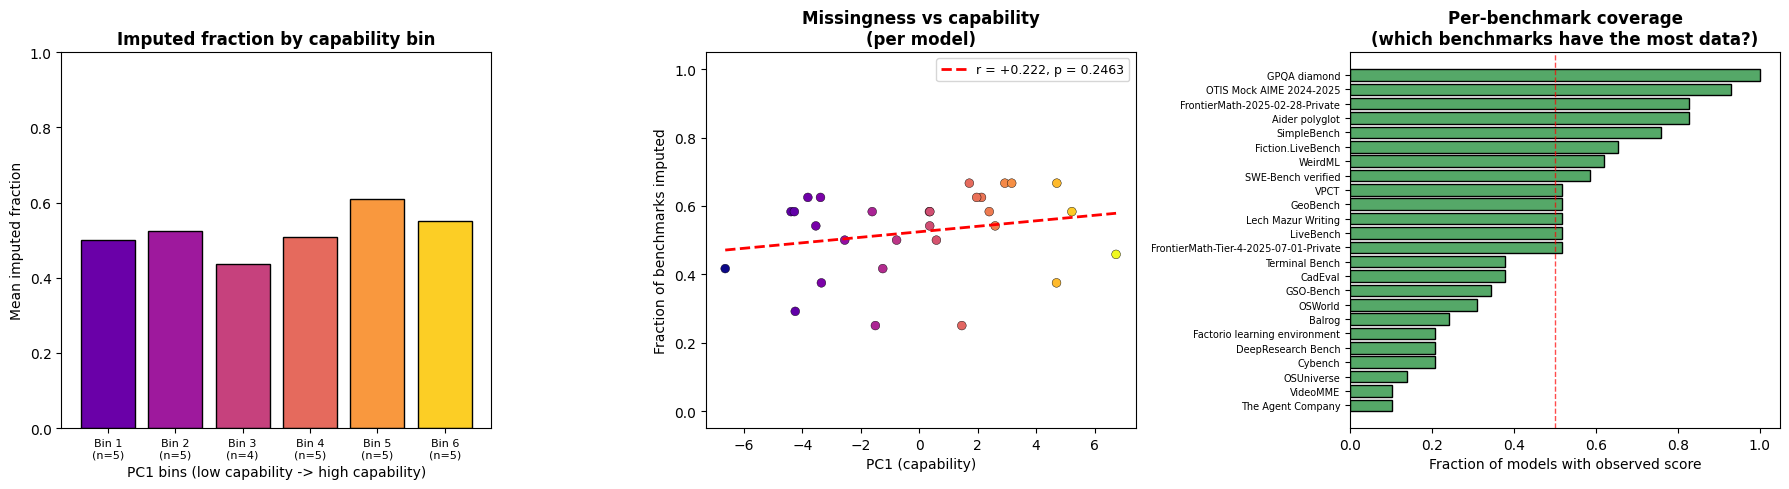

Correlation of imputed fraction with PC1: r = +0.222, p = 0.2463
>> Moderate relationship. Consider sub-analyses.

  BEST RECTANGLE: Dense sub-matrix search
  Iteration 1: 28 models x 13 benchmarks, density = 68.4%
  Iteration 2: 28 models x 13 benchmarks, density = 68.4%
  Iteration 3: 28 models x 13 benchmarks, density = 68.4%
  Iteration 4: 28 models x 13 benchmarks, density = 68.4%
  Iteration 5: 28 models x 13 benchmarks, density = 68.4%

Final rectangle: 28 models x 13 benchmarks, 68.4% observed
Benchmarks in rectangle: GPQA diamond, Fiction.LiveBench, FrontierMath-2025-02-28-Private, GeoBench, Lech Mazur Writing, LiveBench, FrontierMath-Tier-4-2025-07-01-Private, SimpleBench, VPCT, WeirdML, OTIS Mock AIME 2024-2025, SWE-Bench verified, Aider polyglot


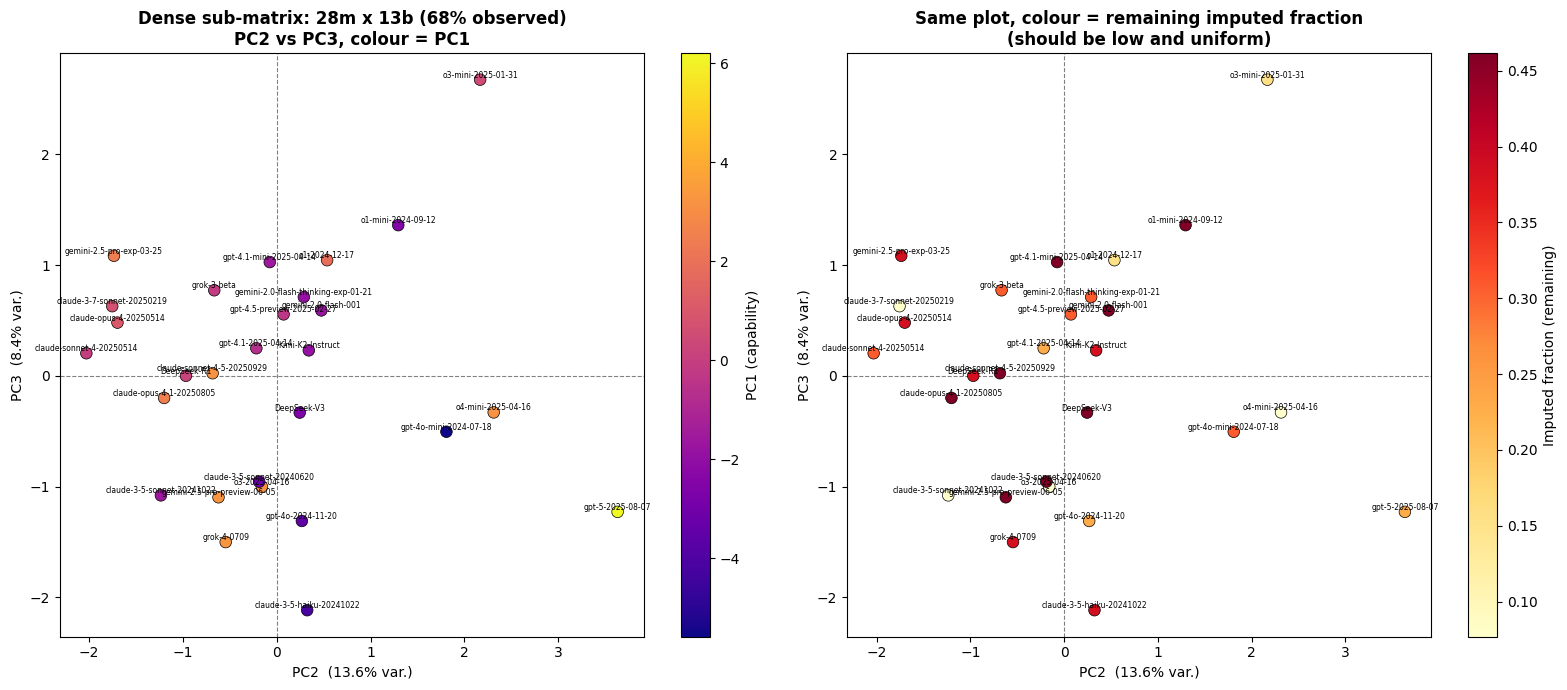


Dense rectangle -- radial distance correlations:
  vs PC1 (capability):     r = +0.312, p = 0.1055
  vs imputed fraction:     r = -0.353, p = 0.0650

Variance explained (dense rectangle):
  PC1: 59.4%
  PC2: 13.6%
  PC3: 8.4%
  PC4: 7.4%
  PC5: 4.1%

  PAIRWISE CORRELATION MATRIX (no imputation needed)
  Using only observed pairwise overlaps to build the correlation matrix.
  This avoids imputation entirely but may produce a non-PSD matrix.



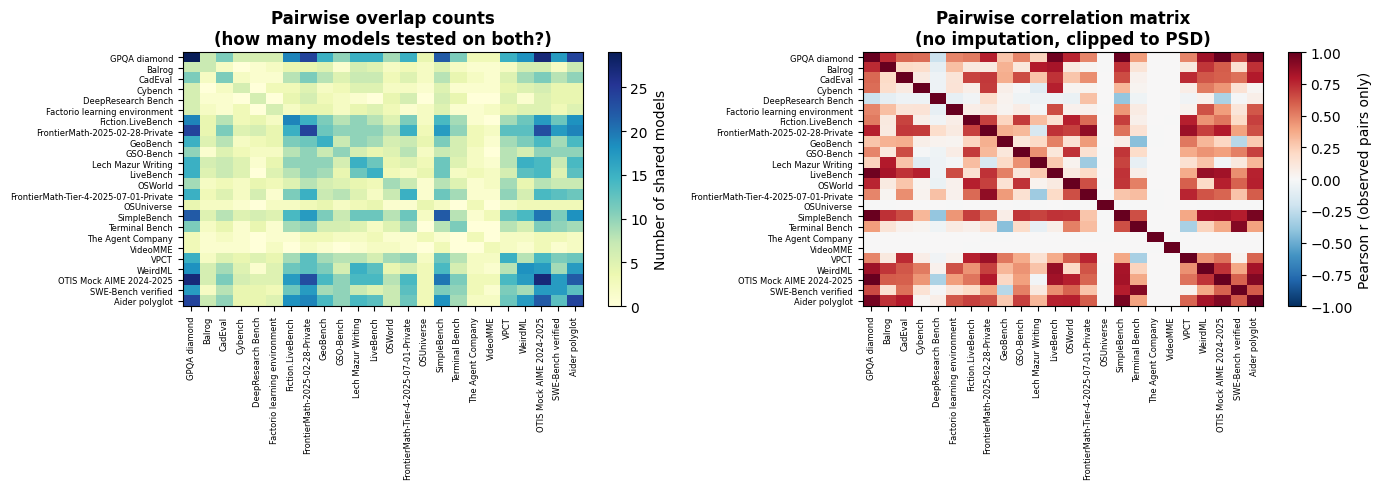

Variance explained from pairwise correlation eigendecomposition:
  PC1: 35.4%
  PC2: 11.1%
  PC3: 10.0%
  PC4: 8.4%
  PC5: 5.1%

Min pairwise overlap: 0 models
Median pairwise overlap: 5 models


In [106]:
# === Imputation Fraction by Bin + Alternative Approaches ===
# Three diagnostics:
#   1. Imputation fraction by PC1 (capability) bin — is the confound real?
#   2. "Best rectangle" approach — find the densest sub-matrix first
#   3. Pairwise-correlation PCA (no imputation needed)

import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer
from scipy.stats import pearsonr

KNN_K = 5
EPS = 1e-6
N_BINS = 6

def expit(z): return 1.0 / (1.0 + np.exp(-z))
def logit(p, eps=EPS):
    p = np.clip(p, eps, 1 - eps)
    return np.log(p / (1 - p))

# ---- pivot ----
M_diag = df_data.pivot_table(index="model_id", columns="benchmark_id", values="performance")
model_names_diag = dict(
    df_data.groupby("model_id")["model"]
    .agg(lambda s: s.dropna().iloc[0] if len(s.dropna()) else str(s.name))
)
bench_names_diag = dict(
    df_data.groupby("benchmark_id")["benchmark"]
    .agg(lambda s: s.dropna().iloc[0] if len(s.dropna()) else str(s.name))
)

# ---- full PCA to get PC1 scores (with imputation, as before) ----
X_full = M_diag.values.astype(float)
X_full_logit = logit(X_full)
imp_full = KNNImputer(n_neighbors=KNN_K, weights="distance")
X_full_imp = expit(imp_full.fit_transform(X_full_logit))
cm_f = X_full_imp.mean(axis=0)
cs_f = X_full_imp.std(axis=0, ddof=1); cs_f[cs_f == 0] = 1.0
Xz_full = (X_full_imp - cm_f) / cs_f
pca_full = PCA(n_components=min(10, Xz_full.shape[1])).fit(Xz_full)
scores_full = pca_full.transform(Xz_full)
pc1_full = scores_full[:, 0]

# ======================================================
# 1. IMPUTATION FRACTION BY PC1 BIN
# ======================================================
observed_mask = M_diag.notna().values  # True where we have real data
model_obs_frac = observed_mask.mean(axis=1)  # per-model observed fraction
model_imp_frac = 1.0 - model_obs_frac

# bin by PC1
bin_edges = np.percentile(pc1_full, np.linspace(0, 100, N_BINS + 1))
bin_edges[0] -= 1; bin_edges[-1] += 1
bin_labels = np.digitize(pc1_full, bin_edges) - 1
bin_labels = np.clip(bin_labels, 0, N_BINS - 1)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Left: imputed fraction per bin
bin_means_imp = []
bin_means_pc1 = []
bin_counts = []
for b in range(N_BINS):
    mask = bin_labels == b
    bin_means_imp.append(model_imp_frac[mask].mean())
    bin_means_pc1.append(pc1_full[mask].mean())
    bin_counts.append(mask.sum())

colors_bins = plt.cm.plasma(np.linspace(0.2, 0.9, N_BINS))
axes[0].bar(range(N_BINS), bin_means_imp, color=colors_bins, edgecolor="black")
axes[0].set_xticks(range(N_BINS))
axes[0].set_xticklabels([f"Bin {b+1}\n(n={bin_counts[b]})" for b in range(N_BINS)], fontsize=8)
axes[0].set_ylabel("Mean imputed fraction")
axes[0].set_xlabel("PC1 bins (low capability -> high capability)")
axes[0].set_title("Imputed fraction by capability bin", fontweight="bold")
axes[0].set_ylim(0, 1)

# Middle: scatter of imputed fraction vs PC1
axes[1].scatter(pc1_full, model_imp_frac, c=pc1_full, cmap="plasma", s=40,
                edgecolors="k", linewidths=0.3)
r_val, p_val = pearsonr(pc1_full, model_imp_frac)
z_fit = np.polyfit(pc1_full, model_imp_frac, 1)
x_line = np.linspace(pc1_full.min(), pc1_full.max(), 100)
axes[1].plot(x_line, np.polyval(z_fit, x_line), "r--", lw=2,
             label=f"r = {r_val:+.3f}, p = {p_val:.4f}")
axes[1].set_xlabel("PC1 (capability)")
axes[1].set_ylabel("Fraction of benchmarks imputed")
axes[1].set_title("Missingness vs capability\n(per model)", fontweight="bold")
axes[1].legend(fontsize=9)
axes[1].set_ylim(-0.05, 1.05)

# Right: per-benchmark coverage
b_labs = [bench_names_diag.get(bid, str(bid)) for bid in M_diag.columns]
bench_obs_frac = observed_mask.mean(axis=0)
order_b = np.argsort(bench_obs_frac)
axes[2].barh(range(len(b_labs)), bench_obs_frac[order_b], color="#55A868", edgecolor="black")
axes[2].set_yticks(range(len(b_labs)))
axes[2].set_yticklabels([b_labs[i] for i in order_b], fontsize=7)
axes[2].set_xlabel("Fraction of models with observed score")
axes[2].set_title("Per-benchmark coverage\n(which benchmarks have the most data?)", fontweight="bold")
axes[2].axvline(0.5, color="red", ls="--", lw=1, alpha=0.7)
plt.tight_layout()
plt.show()

print(f"Correlation of imputed fraction with PC1: r = {r_val:+.3f}, p = {p_val:.4f}")
if r_val < -0.2 and p_val < 0.05:
    print(">> Low-capability models DO have more imputation. Confound is present.")
elif abs(r_val) < 0.1:
    print(">> Missingness is roughly uniform across capability levels. Confound is minimal.")
else:
    print(f">> Moderate relationship. Consider sub-analyses.")

# ======================================================
# 2. BEST RECTANGLE: pick densest sub-matrix
# ======================================================
# Strategy: keep only benchmarks with >=X% coverage, then keep only models
# with >=Y% coverage on those benchmarks. Iteratively tighten.

print("\n" + "=" * 70)
print("  BEST RECTANGLE: Dense sub-matrix search")
print("=" * 70)

M_rect = M_diag.copy()
for iteration in range(5):
    bench_cov = M_rect.notna().mean(axis=0)
    keep_b = bench_cov[bench_cov >= 0.40].index
    M_rect = M_rect[keep_b]

    model_cov = M_rect.notna().mean(axis=1)
    keep_m = model_cov[model_cov >= 0.50].index
    M_rect = M_rect.loc[keep_m]

    density = M_rect.notna().sum().sum() / (M_rect.shape[0] * M_rect.shape[1])
    print(f"  Iteration {iteration+1}: {M_rect.shape[0]} models x {M_rect.shape[1]} benchmarks, density = {density:.1%}")

    if density >= 0.80:
        break

print(f"\nFinal rectangle: {M_rect.shape[0]} models x {M_rect.shape[1]} benchmarks, {density:.1%} observed")

rect_bench_labs = [bench_names_diag.get(bid, str(bid)) for bid in M_rect.columns]
print(f"Benchmarks in rectangle: {', '.join(rect_bench_labs)}")

if M_rect.shape[0] >= 15 and M_rect.shape[1] >= 5:
    # PCA on this dense rectangle
    X_rect = M_rect.values.astype(float)
    X_rect_logit = logit(X_rect)
    imp_rect = KNNImputer(n_neighbors=min(KNN_K, M_rect.shape[0] - 1), weights="distance")
    X_rect_imp = expit(imp_rect.fit_transform(X_rect_logit))
    cm_r = X_rect_imp.mean(axis=0)
    cs_r = X_rect_imp.std(axis=0, ddof=1); cs_r[cs_r == 0] = 1.0
    Xz_rect = (X_rect_imp - cm_r) / cs_r

    n_comp_r = min(10, *Xz_rect.shape)
    pca_rect = PCA(n_components=n_comp_r).fit(Xz_rect)
    scores_rect = pca_rect.transform(Xz_rect)
    evr_rect = pca_rect.explained_variance_ratio_

    m_labs_rect = [model_names_diag.get(mid, str(mid)) for mid in M_rect.index]
    pc1_rect = scores_rect[:, 0]
    rect_model_imp = 1.0 - M_rect.notna().mean(axis=1).values

    if n_comp_r >= 3:
        fig, axes = plt.subplots(1, 2, figsize=(16, 7))

        sc1 = axes[0].scatter(scores_rect[:, 1], scores_rect[:, 2], c=pc1_rect, cmap="plasma",
                              s=70, edgecolors="k", linewidths=0.5, zorder=3)
        plt.colorbar(sc1, ax=axes[0], label="PC1 (capability)")
        axes[0].axhline(0, color="gray", lw=0.8, ls="--"); axes[0].axvline(0, color="gray", lw=0.8, ls="--")
        for i, lbl in enumerate(m_labs_rect):
            axes[0].text(scores_rect[i, 1], scores_rect[i, 2], lbl, fontsize=5.5, ha="center", va="bottom")
        axes[0].set_xlabel("PC2  (" + f"{evr_rect[1]:.1%}" + " var.)")
        axes[0].set_ylabel("PC3  (" + f"{evr_rect[2]:.1%}" + " var.)")
        axes[0].set_title(f"Dense sub-matrix: {M_rect.shape[0]}m x {M_rect.shape[1]}b ({density:.0%} observed)\n"
                          "PC2 vs PC3, colour = PC1", fontweight="bold")

        sc2 = axes[1].scatter(scores_rect[:, 1], scores_rect[:, 2], c=rect_model_imp, cmap="YlOrRd",
                              s=70, edgecolors="k", linewidths=0.5, zorder=3)
        plt.colorbar(sc2, ax=axes[1], label="Imputed fraction (remaining)")
        axes[1].axhline(0, color="gray", lw=0.8, ls="--"); axes[1].axvline(0, color="gray", lw=0.8, ls="--")
        for i, lbl in enumerate(m_labs_rect):
            axes[1].text(scores_rect[i, 1], scores_rect[i, 2], lbl, fontsize=5.5, ha="center", va="bottom")
        axes[1].set_xlabel("PC2  (" + f"{evr_rect[1]:.1%}" + " var.)")
        axes[1].set_ylabel("PC3  (" + f"{evr_rect[2]:.1%}" + " var.)")
        axes[1].set_title("Same plot, colour = remaining imputed fraction\n(should be low and uniform)", fontweight="bold")

        plt.tight_layout()
        plt.show()

        # radial test
        radial_rect = np.sqrt(scores_rect[:, 1]**2 + scores_rect[:, 2]**2)
        r_pc1_r, p_pc1_r = pearsonr(pc1_rect, radial_rect)
        r_imp_r, p_imp_r = pearsonr(rect_model_imp, radial_rect)
        print(f"\nDense rectangle -- radial distance correlations:")
        print(f"  vs PC1 (capability):     r = {r_pc1_r:+.3f}, p = {p_pc1_r:.4f}")
        print(f"  vs imputed fraction:     r = {r_imp_r:+.3f}, p = {p_imp_r:.4f}")

        print(f"\nVariance explained (dense rectangle):")
        for k in range(min(5, n_comp_r)):
            print(f"  PC{k+1}: {evr_rect[k]:.1%}")
    else:
        print("Not enough components for PC2 vs PC3 in the dense rectangle.")
else:
    print(f"Dense rectangle too small ({M_rect.shape[0]} models x {M_rect.shape[1]} benchmarks).")
    print("The data is fundamentally too sparse for imputation-free PCA.")
    print("\nConsider approach 3 below: pairwise-correlation PCA.")

# ======================================================
# 3. PAIRWISE CORRELATION PCA (no imputation)
# ======================================================
print("\n" + "=" * 70)
print("  PAIRWISE CORRELATION MATRIX (no imputation needed)")
print("=" * 70)
print("  Using only observed pairwise overlaps to build the correlation matrix.")
print("  This avoids imputation entirely but may produce a non-PSD matrix.\n")

n_bench = M_diag.shape[1]
corr_mat = np.full((n_bench, n_bench), np.nan)
overlap_counts = np.zeros((n_bench, n_bench), dtype=int)

raw_vals = M_diag.values.astype(float)
for i in range(n_bench):
    for j in range(i, n_bench):
        both_obs = ~np.isnan(raw_vals[:, i]) & ~np.isnan(raw_vals[:, j])
        n_overlap = both_obs.sum()
        overlap_counts[i, j] = overlap_counts[j, i] = n_overlap
        if n_overlap >= 5:
            r, _ = pearsonr(raw_vals[both_obs, i], raw_vals[both_obs, j])
            corr_mat[i, j] = corr_mat[j, i] = r
        else:
            corr_mat[i, j] = corr_mat[j, i] = 0.0
    corr_mat[i, i] = 1.0

# fix any remaining NaN
corr_mat = np.nan_to_num(corr_mat, nan=0.0)

# nearest PSD projection (eigenvalue clipping)
eigvals, eigvecs = np.linalg.eigh(corr_mat)
eigvals_clipped = np.maximum(eigvals, 0)
corr_psd = eigvecs @ np.diag(eigvals_clipped) @ eigvecs.T
np.fill_diagonal(corr_psd, 1.0)

# eigendecomposition for variance explained
total_var = eigvals_clipped.sum()
evr_pw = eigvals_clipped[::-1] / total_var if total_var > 0 else eigvals_clipped

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: pairwise overlap counts
im1 = axes[0].imshow(overlap_counts, cmap="YlGnBu", aspect="auto")
plt.colorbar(im1, ax=axes[0], label="Number of shared models")
b_labs_d = [bench_names_diag.get(bid, str(bid)) for bid in M_diag.columns]
axes[0].set_xticks(range(n_bench))
axes[0].set_xticklabels(b_labs_d, rotation=90, fontsize=6)
axes[0].set_yticks(range(n_bench))
axes[0].set_yticklabels(b_labs_d, fontsize=6)
axes[0].set_title("Pairwise overlap counts\n(how many models tested on both?)", fontweight="bold")

# Right: pairwise correlation matrix
im2 = axes[1].imshow(corr_psd, cmap="RdBu_r", vmin=-1, vmax=1, aspect="auto")
plt.colorbar(im2, ax=axes[1], label="Pearson r (observed pairs only)")
axes[1].set_xticks(range(n_bench))
axes[1].set_xticklabels(b_labs_d, rotation=90, fontsize=6)
axes[1].set_yticks(range(n_bench))
axes[1].set_yticklabels(b_labs_d, fontsize=6)
axes[1].set_title("Pairwise correlation matrix\n(no imputation, clipped to PSD)", fontweight="bold")

plt.tight_layout()
plt.show()

print("Variance explained from pairwise correlation eigendecomposition:")
for k in range(min(5, len(evr_pw))):
    print(f"  PC{k+1}: {evr_pw[k]:.1%}")
print(f"\nMin pairwise overlap: {overlap_counts[np.triu_indices(n_bench, k=1)].min()} models")
print(f"Median pairwise overlap: {int(np.median(overlap_counts[np.triu_indices(n_bench, k=1)]))} models")
